# Cogs 118b Final Project 
## Comparing and Contrasting the Performance of Different Machine Learning Models on clustering and classifying animal sounds 

Group Members:
- Anand Mysorekar
- Alex Franz
- Jack Determan
- Austin Blanco

# Abstract

This study evaluates the performance of various machine learning models for clustering and classifying animal sounds, comparing their effectiveness across different feature extraction techniques. Using audio data sourced from multiple animal classes, we employed Librosa and spectrogram-based features as well as MobileNet, a pre-trained convolutional neural network, for feature extraction. Clustering methods included K-Means, Spectral Clustering, Gaussian Mixture Models (GMM), and Self-Organizing Maps (SOM), while classification tasks used Logistic Regression, Recurrent Neural Networks (RNN), Support Vector Machines (SVM), and XGBoost. Results demonstrated that Librosa-extracted features outperformed spectrogram features in clustering tasks, achieving higher Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI) scores. For classification, SVM marginally outperformed other methods, achieving an accuracy of 73%. The findings highlight the importance of feature extraction techniques in audio analysis and suggest that leveraging pre-trained neural networks can improve classification outcomes. However, computational limitations restricted our ability to experiment with more complex models, leaving room for future exploration.

# Introduction

The analysis of animal sounds is an extremely valuable tool in biology and environmental science, offering insights into species behavior, communication patterns, and environmental health. Applications of audio analysis range from wildlife conservation to advanced AI-driven sound recognition systems. Despite its growing importance, effectively clustering and classifying animal sounds remains a challenging task, owing to the variability of audio recordings and the inherent noise in real-world data.

Clustering and classification are two complementary challenges in audio analysis. Clustering groups sounds based on underlying patterns without prior labels, while classification assigns predefined labels, such as identifying the species that produced the sound. These are extremely important for organizing and interpreting audio data, but they present unique challenges, such as overlapping frequency ranges and inconsistencies in recording conditions.

Our dataset comprises audio recordings of various animal species, providing a wide array of sounds for analysis. The variety in the dataset allows us to test the effectiveness of different machine learning models and feature extraction techniques in handling complex audio data. Feature extraction, a critical step in this pipeline, transforms raw waveforms into meaningful representations. In this study, we explore traditional methods, such as Librosa-extracted features and spectrograms, alongside features derived from MobileNet, a pre-trained convolutional neural network.

# Related Works

The use of machine learning for animal audio classification has been explored in various studies, emphasizing the importance of feature extraction techniques and model selection. Mporas et al. (2012) conducted a study on the automated acoustic classification of bird species using real-field recordings. Their approach involved extracting Mel-Frequency Cepstral Coefficients (MFCCs) as features, which were fed into multiple classification algorithms, including k-Nearest Neighbors (k-NN), Support Vector Machines (SVM), and Gaussian Mixture Models (GMM). The study highlighted the effectiveness of MFCCs in capturing audio characteristics relevant for species differentiation. Among the algorithms, SVM demonstrated strong performance due to its ability to handle high-dimensional feature spaces, while GMM excelled in modeling the probabilistic distribution of the features. This study underscores the utility of combining traditional feature extraction methods with versatile classifiers, informing our use of Librosa-extracted features and SVM in this work.

More recently, Kahl et al. (2020) reviewed bioacoustic classification techniques, emphasizing the growing role of convolutional neural networks (CNNs) in feature extraction. Key results from this study demonstrated that CNN-based methods, when combined with spectrogram representations, consistently outperformed traditional feature extraction approaches in accuracy and robustness. They also highlighted specific architectures, such as ResNet and VGG, which achieved high precision on datasets like BirdCLEF and amphibian call collections. These findings reinforce the effectiveness of neural networks for complex bioacoustic classification tasks and inspired the adoption of MobileNet in our feature extraction pipeline to leverage its high-dimensional representation capabilities.

While most studies focus on bird sounds or specific species, this study broadens the scope to include a diverse dataset of animal sounds. Few works have explored clustering in this context, with existing studies typically focusing on classification. 

# Methods

This study involved a pipeline to evaluate the effectiveness of various feature extraction methods and machine learning models for clustering and classifying animal sounds. The methods are structured as follows:

### Feature Extraction
We explored three distinct feature extraction techniques to represent audio data:
1. **Librosa-Extracted Features**: Leveraging the Librosa library, we extracted Mel-Frequency Cepstral Coefficients (MFCCs), Zero-Crossing Rate, and Spectral Centroid. These features capture timbral, rhythmic, and spectral aspects of sound, providing a compact representation of the audio signals.
2. **Spectrograms**: Time-frequency representations of audio signals were generated and converted into numerical features using dimensionality reduction techniques like Principal Component Analysis (PCA).
3. **MobileNet**: A pre-trained MobileNet convolutional neural network was used as a feature extractor. Audio files were transformed into image-like representations and passed through MobileNet, with its convolutional layers frozen, to extract high-dimensional embeddings.

### Clustering Models
We applied the following clustering algorithms to group audio data based on patterns in extracted features:
- **K-Means**: A popular centroid-based algorithm that partitions data into clusters by minimizing intra-cluster variance.
- **Spectral Clustering**: Utilizes graph-based approaches to identify clusters, particularly effective for non-linearly separable data.
- **Gaussian Mixture Models (GMM)**: A probabilistic model that assumes data points are generated from a mixture of multiple Gaussian distributions.
- **Self-Organizing Maps (SOM)**: A type of artificial neural network used for dimensionality reduction and visualization of clustering structures.

### Classification Models
For supervised learning, we trained the following classifiers on the extracted features:
- **Logistic Regression**: A linear model for binary classification, extended here to multi-class classification using one-vs-rest encoding.
- **Recurrent Neural Networks (RNN)**: Leveraging temporal dependencies in audio data to capture sequence-based patterns.
- **Support Vector Machines (SVM)**: A kernel-based approach to finding optimal hyperplanes for classification.
- **XGBoost**: A gradient-boosting framework optimized for speed and performance, particularly effective for tabular data.

### Evaluation Metrics
We used appropriate metrics to assess the performance of both clustering and classification models:
- **Clustering Metrics**:
  - **Adjusted Rand Index (ARI)**: Measures the similarity between predicted and true clusters, adjusted for chance.
  - **Normalized Mutual Information (NMI)**: Quantifies the amount of information shared between predicted and true clusters.
  - **Homogeneity and Completeness**: Reflect the consistency of clusters with true class labels.
- **Classification Metrics**:
  - **Accuracy**: The proportion of correctly classified samples.
  - **Interpretability**: Qualitative evaluation of the classifier's decision boundaries and feature importance.

By applying these methods, we aimed to compare the effectiveness of traditional and neural feature extraction techniques, along with clustering and classification algorithms, in analyzing animal sound data.


# Data Preprocessing, Feature Extraction, PCA, and Clustering



## Imports

In [1]:
import os
import warnings
import subprocess
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from scipy.io import wavfile
from skimage.transform import resize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.cluster import SpectralClustering, KMeans
from sklearn.mixture import GaussianMixture
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    adjusted_rand_score, normalized_mutual_info_score, homogeneity_score, 
    completeness_score, v_measure_score, classification_report, confusion_matrix
)
from minisom import MiniSom
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    LSTM, Dense, Dropout, TimeDistributed, GlobalAveragePooling2D, 
    Attention, Bidirectional
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, AdamW
from tensorflow.keras.applications import MobileNet



## Extracting Features using Librosa

Some commonly used audio features for classification include:

* **MFCCs (Mel-Frequency Cepstral Coefficients)**: Captures the timbral aspects of the sound, which is crucial for distinguishing sounds with similar pitches but different characteristics
* **Spectral Features**: Describes the shape of the spectrum and provide insights into the distribution of energy across frequencies
    * **Spectral Centroid**: Associated with brightness. Sounds with high spectral centroids (e.g., cymbals) are perceived as brighter, while sounds with low centroids (e.g., bass) are darker.
    * **Spectral Bandwidth**: A high bandwidth means the sound contains a wide range of frequencies (e.g., noise), while a narrow bandwidth suggests a pure tone
    * **Spectral Rolloff**: Indicates the "tail" of the spectrum. Useful for distinguishing tonal sounds (low rolloff) from noise-like sounds (high rolloff)
    * **Zero-Crossing Rate**: Higher rates are associated with noisier or percussive sounds, while lower rates occur in harmonic or tonal sounds
* **RMS Energy**: Loudness
*  **Chroma Features**: Rate of sign changes in the waveform 

In [2]:
def extract_features(file_path):

    y, sr = librosa.load(file_path, sr=None) 

    # MFCCs
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  
    mfccs_mean = np.mean(mfccs, axis=1)  

    # Spectral features
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    spectral_bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr))
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr))
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=y))

    # RMS energy
    rms = np.mean(librosa.feature.rms(y=y))

    # Combine all features into a single vector
    features = np.hstack([
        mfccs_mean,
        spectral_centroid,
        spectral_bandwidth,
        spectral_rolloff,
        zero_crossing_rate,
        rms
    ])
    
    return features

def process_audio_directory(directory_path):

    data = []

    for file_name in os.listdir(directory_path):
        if file_name.endswith('.wav'):  
            file_path = os.path.join(directory_path, file_name)
            
            try:
                features = extract_features(file_path)
                
                data.append([file_name] + list(features))
            except Exception as e:
                print(f"Error processing {file_name}: {e}")
    
    mfcc_columns = [f"mfcc_{i+1}" for i in range(13)]
    other_columns = ["spectral_centroid", "spectral_bandwidth", "spectral_rolloff", "zero_crossing_rate", "rms"]
    columns = ["file_name"] + mfcc_columns + other_columns

    df = pd.DataFrame(data, columns=columns)

    return df

def process_audio_directory_recursive(directory_path):
    
    data = []

    for root, _, files in os.walk(directory_path):
        for file_name in files:
            if file_name.endswith('.wav'): 
                file_path = os.path.join(root, file_name)
                
                try:
                    features = extract_features(file_path)
                    
                    data.append([file_name, file_path] + list(features))
                except Exception as e:
                    print(f"Error processing {file_name}: {e}")
    
    mfcc_columns = [f"mfcc_{i+1}" for i in range(13)]
    other_columns = ["spectral_centroid", "spectral_bandwidth", "spectral_rolloff", "zero_crossing_rate", "rms"]
    columns = ["file_name", "file_path"] + mfcc_columns + other_columns

    df = pd.DataFrame(data, columns=columns)
    return df

def plot_and_compute_metrics(df, model, expected_clusters, expected_labels):

    plt.figure(figsize=(10, 6))
    sns.heatmap(model, annot=True, fmt='d', cmap='Blues', xticklabels=expected_clusters, yticklabels=expected_labels)
    plt.xlabel('Cluster')
    plt.ylabel('Animal Label')
    plt.title('Counts of Animal Labels per Cluster')
    plt.show()

    ari = adjusted_rand_score(df['animal_label'], df['cluster'])
    print(f"Adjusted Rand Index (ARI): {ari:.2f}")

    nmi = normalized_mutual_info_score(df['animal_label'], df['cluster'])
    print(f"Normalized Mutual Information (NMI): {nmi:.2f}")

    homogeneity = homogeneity_score(df['animal_label'], df['cluster'])
    print(f"Homogeneity Score: {homogeneity:.2f}")

    completeness = completeness_score(df['animal_label'], df['cluster'])
    print(f"Completeness Score: {completeness:.2f}")

    v_measure = v_measure_score(df['animal_label'], df['cluster'])
    print(f"V-Measure Score: {v_measure:.2f}")

In [3]:
bear_file = "Animal_Sounds/Bear/Bear_1.wav"
bear_dir = "Animal_Sounds/Bear"
animal_dir = "Animal_Sounds"
animals = ["Animal_Sounds/Bear/Bear_1.wav","Animal_Sounds/Cat/Cat_1.wav","Animal_Sounds/Chicken/tavuk_1.wav","Animal_Sounds/Lion/Lion_1.wav"]

In [4]:
bear_sample = extract_features(bear_file)
print(bear_sample)

all_data = process_audio_directory_recursive(animal_dir)
all_data

[-4.26974411e+01  2.31592064e+01 -2.15544968e+01  2.83187695e+01
 -2.24801407e+01 -2.08504272e+00 -5.42245216e+01 -1.95991497e+01
 -1.69385281e+01 -1.93927460e+01 -2.62231503e+01 -2.08692589e+01
 -3.87858152e+00  1.45384062e+03  9.86992091e+02  2.64183728e+03
  2.45319235e-01  1.45496503e-01]


,file_name,file_path,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,spectral_centroid,spectral_bandwidth,spectral_rolloff,zero_crossing_rate,rms
0,aslan_1.wav,Animal_Sounds\Bear\aslan_1.wav,-245.370361,79.578293,22.363941,-18.475544,11.912645,-22.901335,-2.513403,2.549281,-14.802592,-7.953619,-11.674826,-9.344398,-16.333115,3166.955500,3466.780060,7905.793432,0.136100,0.055283
1,aslan_10.wav,Animal_Sounds\Bear\aslan_10.wav,-72.543793,125.980103,-4.384604,13.756566,20.629997,-13.832855,-22.099659,-9.363855,-8.422581,-2.752330,0.676186,11.414459,-1.585902,852.439750,994.559279,1560.121976,0.071289,0.192413
2,aslan_11.wav,Animal_Sounds\Bear\aslan_11.wav,-40.297764,104.890320,-16.957306,8.785254,-10.214172,-1.037464,-6.632132,-10.494173,-9.749370,-11.080574,-10.847469,-13.123822,-12.238956,1050.596043,1098.148279,2087.082307,0.094875,0.158918
3,aslan_12.wav,Animal_Sounds\Bear\aslan_12.wav,-166.619492,99.968857,-35.624809,11.128350,7.054768,-4.444332,14.727487,-4.358776,-4.698819,-3.639993,-6.527721,-0.025633,-15.869770,1117.938561,1098.915283,2075.401457,0.067711,0.064886
4,aslan_13.wav,Animal_Sounds\Bear\aslan_13.wav,-223.101379,101.745384,-44.985474,12.924060,-7.510344,4.448566,-1.773097,-17.642694,-11.838638,-9.732849,-10.745259,-10.981558,-8.577792,1167.625922,977.458031,2144.324534,0.156629,0.064850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
951,koyun_5.wav,Animal_Sounds\Sheep\koyun_5.wav,-287.285675,36.589062,-61.353466,15.849582,-11.927240,-10.501649,-0.102232,6.459758,-3.549141,27.856552,19.528688,-0.552656,-4.444294,1184.249515,995.663524,1920.776883,0.119512,0.059410
952,koyun_6.wav,Animal_Sounds\Sheep\koyun_6.wav,-134.427032,33.744381,-12.441479,-1.117791,-8.601460,4.622550,5.768901,0.602946,10.971403,-8.813649,-11.505404,8.491366,-14.898542,1465.123488,1093.129117,2760.937500,0.167773,0.033424
953,koyun_7.wav,Animal_Sounds\Sheep\koyun_7.wav,-123.774612,41.465889,-34.838017,13.756769,6.211781,-8.981025,-0.221999,11.738886,6.113473,7.464331,4.812810,7.383133,2.999784,1486.505120,1258.259525,2774.675769,0.136659,0.185735
954,koyun_8.wav,Animal_Sounds\Sheep\koyun_8.wav,-287.285675,36.589062,-61.353466,15.849582,-11.927240,-10.501649,-0.102232,6.459758,-3.549141,27.856552,19.528688,-0.552656,-4.444294,1184.249515,995.663524,1920.776883,0.119512,0.059410


### Run PCA on the librosa-extracted features

Number of components selected: 13
Explained Variance Ratio: [0.26420085 0.11780065 0.10460981 0.07615927 0.07460546 0.06046135
 0.04978514 0.04527969 0.04093858 0.03537865 0.03394648 0.03083501
 0.02397616]
Total variance explained: 0.96
          0         1         2         3         4         5         6  \
0  1.531917 -1.645781 -0.763585  0.396079 -2.937497 -1.045515 -0.414358   
1 -2.610359  0.121695  0.886849 -0.739757 -0.454588 -0.756349  1.471317   
2 -2.368356  0.278120 -0.991527  0.307041 -1.512269  0.220204 -0.604247   
3 -0.985034  0.028345  0.604237  0.148466 -1.523396  0.465689 -0.570730   
4 -1.517862 -0.105411 -0.429660 -0.678660 -1.192459 -0.103483 -1.391495   

          7         8         9        10        11        12 animal_label  
0 -0.802114 -0.166762  0.956126 -2.049402 -0.624119  0.962226        aslan  
1 -0.788996  1.397101 -0.491225 -0.669930 -0.121641  0.254613        aslan  
2  0.362513  0.534387  0.053281 -0.047898  0.250625  0.230663        aslan  
3 -

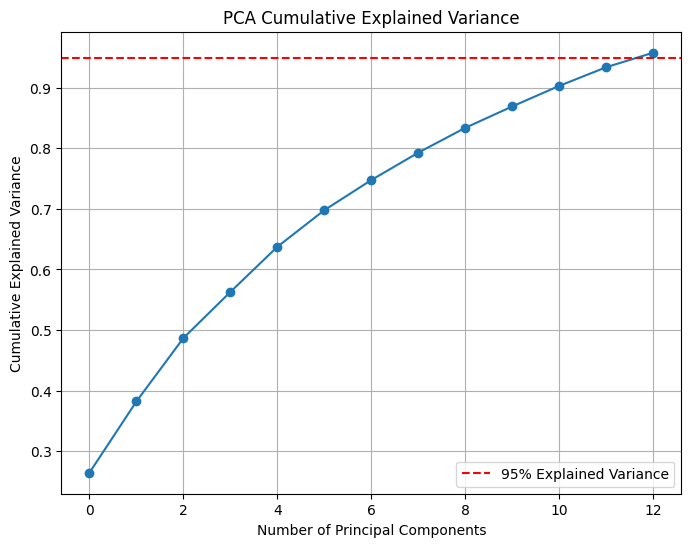

In [5]:
# Drop non-numeric columns
animal_features = all_data.drop(columns=["file_name","file_path"])  

# Standardize the data
scaler = StandardScaler()
animal_scaled = scaler.fit_transform(animal_features)

# Apply PCA 
pca = PCA(n_components=0.95)  
principal_components_librosa = pca.fit_transform(animal_scaled)

# Create a DataFrame for PCA results
pca_df = pd.DataFrame(data=principal_components_librosa)

print(f"Number of components selected: {pca.n_components_}")
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.2f}")

pca_df['file_name'] = all_data['file_name'].values
pca_df['animal_label'] = pca_df['file_name'].str.split('_').str[0]
pca_df = pca_df.drop(columns=["file_name"]) 
print(pca_df.head())

# Plot the cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label="95% Explained Variance")
plt.legend(loc='best')
plt.grid()
plt.show()

### Perform KMeans clustering on the principal components

cluster        0   1   2   3   4   5   6   7   8   9
animal_label                                        
Bear           2   0   0   9   0   1  24   0  14   0
Cow            7   2   0  16   0  14   3   1   5   2
Dolphin        0   0   0   0   0   0   9  31   1   9
Donkey         0   0   0   3   0  22   1  12   4   8
Elephant      10   2   0   6   5   2   1   6   0  18
Frog           4   4   0   3   4  15   8   3   5   4
Horse          1   0   0   1   1   0   3  17   7   1
Kus            0   0  40   0  60   0   0   0   0   0
Lion          20   0   0  13   1   2   4   0  10   0
aslan         20   0   0  13   0   2   1   0   9   0
cat            6   2   0   9   0   4  39   7  28   5
dog           10  70   0   1   0   1   8   0  10   0
esek           0   0   0   3   0  15   0   0   1   6
inek          11   3   0  22   0  21   3   1  10   4
koyun          0   1   1   0   1  10   4   7   1  15
kurbaga        4   3   0   2   1  11   4   2   4   4
maymun         3   0   1   1   1   2   6   4  

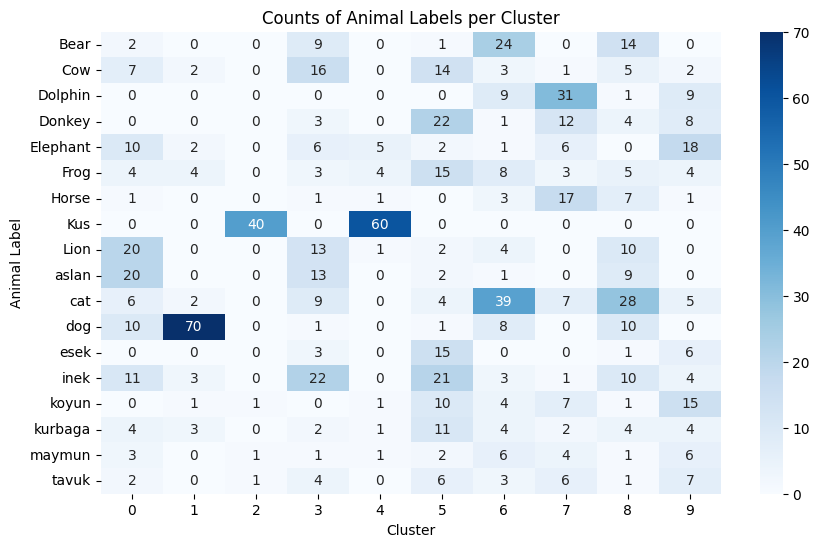

Adjusted Rand Index (ARI): 0.19
Normalized Mutual Information (NMI): 0.33
Homogeneity Score: 0.30
Completeness Score: 0.37
V-Measure Score: 0.33


In [6]:
# Run K-means clustering
kmeans = KMeans(n_clusters=10, random_state=42)
pca_df['cluster'] = kmeans.fit_predict(principal_components_librosa)

# Create a contingency matrix
contingency_matrix_k_means = pd.crosstab(pca_df['animal_label'], pca_df['cluster'])

# Ensure all clusters and labels are represented
expected_clusters = range(kmeans.n_clusters)
expected_labels = sorted(pca_df['animal_label'].unique())

# Reindex the contingency matrix to include all expected clusters and labels
contingency_matrix_k_means = contingency_matrix_k_means.reindex(index=expected_labels, columns=expected_clusters, fill_value=0)
print(contingency_matrix_k_means)

plot_and_compute_metrics(pca_df, contingency_matrix_k_means, expected_clusters, expected_labels)

### Perform Spectral Clustering on the principal components

cluster        0   1   2   3   4   5   6  7   8
animal_label                                   
Bear           0   0   7  37   0   0   0  4   0
Cow            1   0   7   5   0   0   0  8   1
Dolphin       37   0   0  10   0   0   0  0   0
Donkey        12   0   0   6   0   0   0  0   0
Elephant       7   3  12   4   0   0   0  0   1
Frog           3   0  10  15   0   0  10  0   0
Horse         16   0   2  10   0   0   0  0   0
Kus            0  46   0   0  40  14   0  0   0
Lion           0   0  34   8   0   0   0  0   0
aslan          0   0  33   3   0   0   0  0   0
cat            1   0  15  64   0   0   0  0   0
dog            0   0  27   9   0   0   0  0  59
esek           3   0   0   0   0   0   0  0   0
inek           3   0   9  12   0   0   0  8   1
koyun         11   0   1   5   0   0   0  0   0
kurbaga        3   0   8   7   0   0   7  0   0
maymun         6   0   4   7   1   0   0  0   0
tavuk          2   0   4   8   0   0   0  0   0


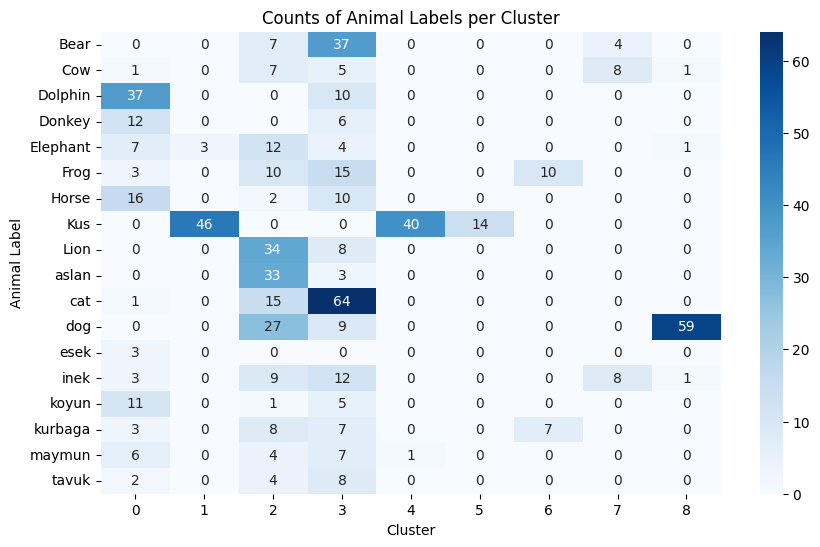

Adjusted Rand Index (ARI): 0.14
Normalized Mutual Information (NMI): 0.37
Homogeneity Score: 0.31
Completeness Score: 0.45
V-Measure Score: 0.37


In [7]:
# Run Spectral Clustering
spectral = SpectralClustering(n_clusters=10, affinity='nearest_neighbors', random_state=42)
pca_df['cluster'] = spectral.fit_predict(principal_components_librosa)

# Create a contingency matrix
contingency_matrix_spectral = pd.crosstab(pca_df['animal_label'], pca_df['cluster'])

# Ensure all clusters and labels are represented
expected_clusters = range(9)  
expected_labels = sorted(pca_df['animal_label'].unique())

# Reindex the contingency matrix to include all expected clusters and labels
contingency_matrix_spectral = contingency_matrix_spectral.reindex(index=expected_labels, columns=expected_clusters, fill_value=0)
print(contingency_matrix_spectral)

plot_and_compute_metrics(pca_df, contingency_matrix_spectral, expected_clusters, expected_labels)

### Perform GMM clustering on the principal components

cluster        0   1   2   3   4   5   6   7   8
animal_label                                    
Bear           0   0   0  11   0   0   4   0  34
Cow            9   1   0  16   0  11   7   0   3
Dolphin        0   0   0   0   0   0   7  28   2
Donkey         0   0   0   2   0  21   3  10   1
Elephant      11   0   0   2   0   2  14   1   0
Frog           5   3   0   2   2  15  10   2   4
Horse          4   0   0   0   0   0   4  13   5
Kus            0   0  40   0  59   0   1   0   0
Lion           8   0   0  15   0   1  10   0  16
aslan          8   0   0  15   0   1   5   0  16
cat            6   1   0  14   0   0  10   2  57
dog            6  61   0  12   0   1   9   0   9
esek           0   0   0   1   0  14   2   0   0
inek          13   1   0  21   0  15  11   0   5
koyun          1   1   1   0   1   3   7   7   0
kurbaga        5   3   0   2   1  10   2   2   3
maymun         2   0   1   0   0   2   7   4   2
tavuk          7   0   1   2   0   1  16   2   0


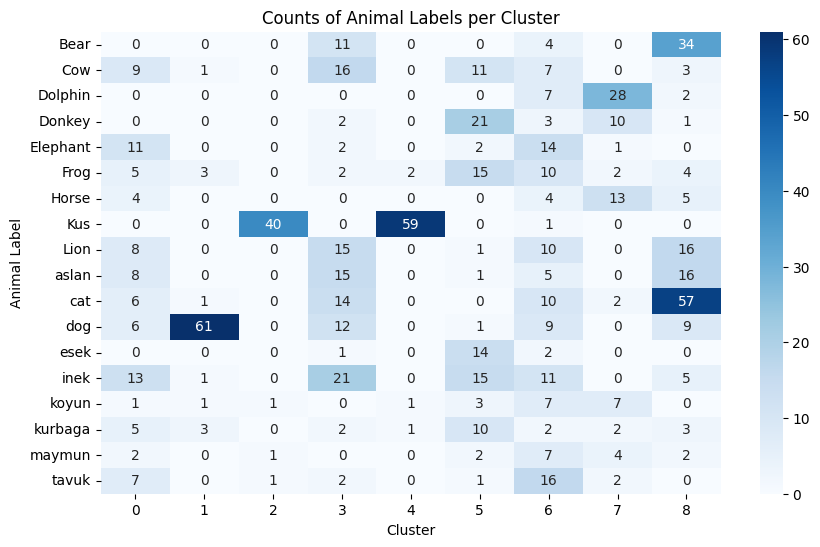

Adjusted Rand Index (ARI): 0.19
Normalized Mutual Information (NMI): 0.35
Homogeneity Score: 0.31
Completeness Score: 0.39
V-Measure Score: 0.35


In [8]:
# Run Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=10, random_state=42)
pca_df['cluster'] = gmm.fit_predict(principal_components_librosa)

# Create a contingency matrix
contingency_matrix_gmm = pd.crosstab(pca_df['animal_label'], pca_df['cluster'])

# Ensure all clusters and labels are represented
expected_clusters = range(9) 
expected_labels = sorted(pca_df['animal_label'].unique())

# Reindex the contingency matrix to include all expected clusters and labels
contingency_matrix_gmm = contingency_matrix_gmm.reindex(index=expected_labels, columns=expected_clusters, fill_value=0)
print(contingency_matrix_gmm)

plot_and_compute_metrics(pca_df, contingency_matrix_gmm, expected_clusters, expected_labels)

### Perform Self-Organizing Maps clustering on the principal components

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 1.8930988267026718


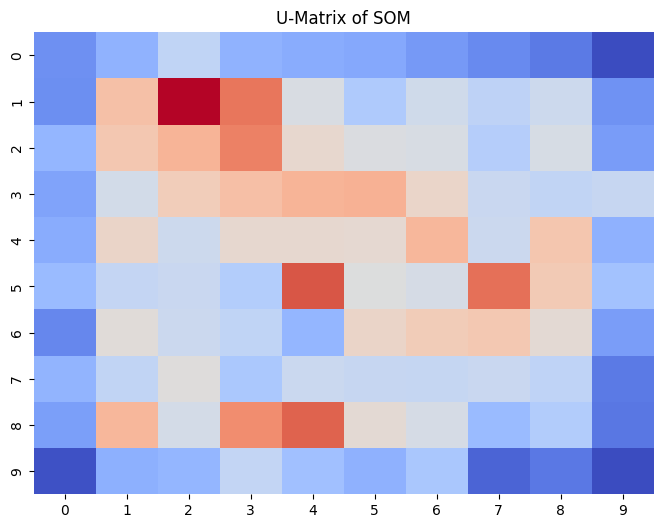

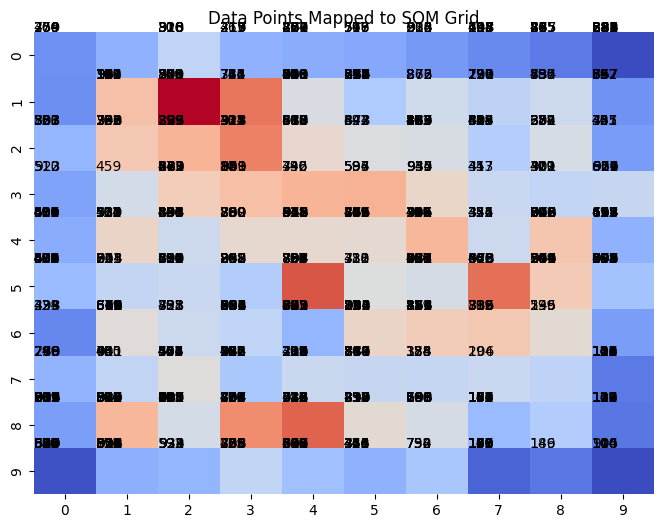

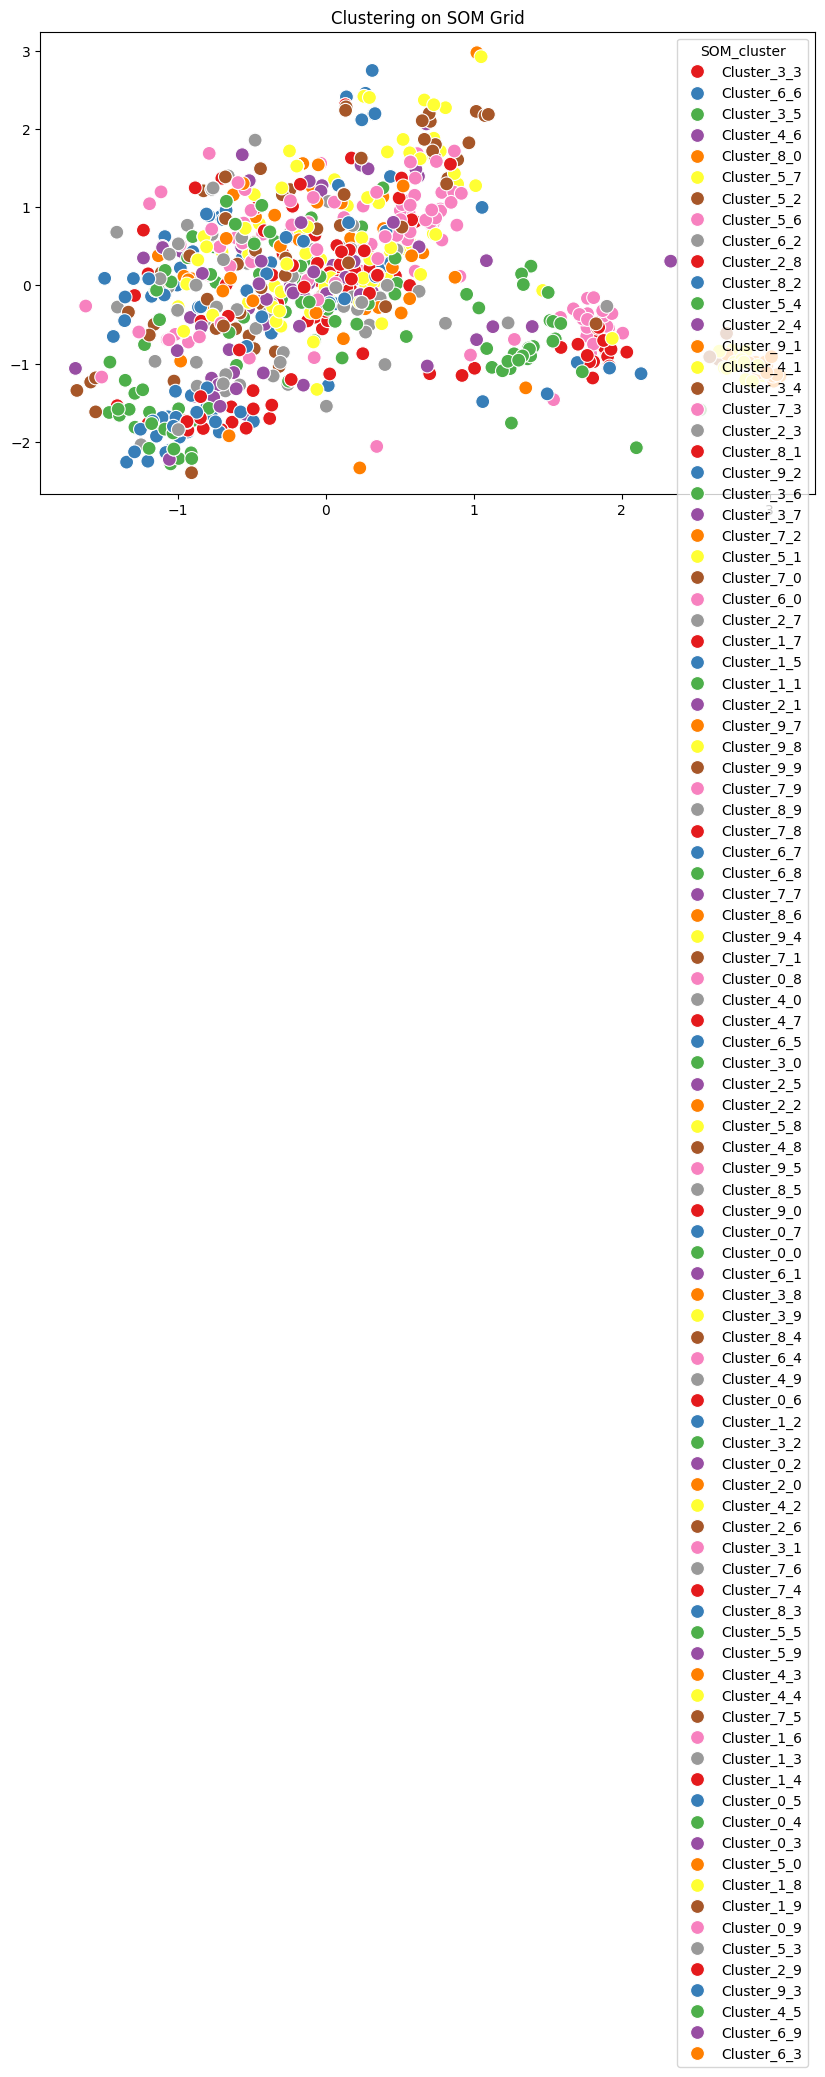

Adjusted Rand Index (ARI): 0.12
Normalized Mutual Information (NMI): 0.47
Homogeneity: 0.60
Completeness: 0.38
V-Measure: 0.47


In [9]:
# Standardize the data 
scaler = StandardScaler()
animal_scaled = scaler.fit_transform(principal_components_librosa) 

# Initialize the SOM
som = MiniSom(x=10, y=10, input_len=animal_scaled.shape[1], sigma=1.0, learning_rate=0.5, random_seed=42)

# Train the SOM
som.train(animal_scaled, 1000, verbose=True)

# Plot the SOM's U-matrix
# U-matrix visualizes the distance between the neurons in the SOM grid. Larger distances mean dissimilarity.
plt.figure(figsize=(8, 6))
plt.title("U-Matrix of SOM")
sns.heatmap(som.distance_map().T, cmap='coolwarm', cbar=False)
plt.show()

# Plot the data points on the SOM grid
plt.figure(figsize=(8, 6))
sns.heatmap(som.distance_map().T, cmap='coolwarm', cbar=False)

# Assign each data point to a neuron (winning node)
win_map = som.win_map(animal_scaled)

# We can use the same colors to show where the data points map on the SOM grid
for label in range(len(animal_scaled)):
    x, y = som.winner(animal_scaled[label])
    plt.text(x, y, str(label), color='black', fontsize=10)

plt.title('Data Points Mapped to SOM Grid')
plt.show()

# Visualize the SOM clusters
# Cluster the data points by grouping based on their winning node
# You can assign each point a cluster label (i.e., the coordinates of the winning node)
labels_som = np.array([som.winner(x) for x in animal_scaled])

# Convert coordinates to cluster labels
cluster_labels = np.array([f'Cluster_{x[0]}_{x[1]}' for x in labels_som])

pca_df['SOM_cluster'] = cluster_labels

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=animal_scaled[:, 0], y=animal_scaled[:, 1], hue=pca_df['SOM_cluster'], palette='Set1', s=100)
plt.title("Clustering on SOM Grid")
plt.show()

# Clustering performance metrics
ari = adjusted_rand_score(pca_df['animal_label'], pca_df['SOM_cluster'])
print(f"Adjusted Rand Index (ARI): {ari:.2f}")

nmi = normalized_mutual_info_score(pca_df['animal_label'], pca_df['SOM_cluster'])
print(f"Normalized Mutual Information (NMI): {nmi:.2f}")

homogeneity = homogeneity_score(pca_df['animal_label'], pca_df['SOM_cluster'])
print(f"Homogeneity: {homogeneity:.2f}")

completeness = completeness_score(pca_df['animal_label'], pca_df['SOM_cluster'])
print(f"Completeness: {completeness:.2f}")

v_measure = v_measure_score(pca_df['animal_label'], pca_df['SOM_cluster'])
print(f"V-Measure: {v_measure:.2f}")

### Results of Librosa Feature Extraction Clustering Results

| **Method**              | **Adjusted Rand Index (ARI)** | **Normalized Mutual Information (NMI)** | **Homogeneity Score** | **Completeness Score** | **V-Measure Score** |
|--------------------------|------------------------------|------------------------------------------|------------------------|-------------------------|---------------------|
| K-means                 | 0.19                         | 0.33                                     | 0.30                   | 0.37                    | 0.33                |
| Spectral Clustering      | 0.14                         | 0.37                                     | 0.31                   | 0.45                    | 0.37                |
| GMM                     | 0.19                         | 0.35                                     | 0.31                   | 0.39                    | 0.35                |
| SOM                     | 0.12                         | 0.47                                     | 0.60                   | 0.38                    | 0.47                |


## Processing the File using a Spectrogram 

The code below processes and visuailzes a directory of `.wav` files, extracting spectrogram features and storing them in a pandas DataFrame. 

1. **Initialize Storage**:
   - Create an empty list `data` to store the flattened spectrograms.
   - Create another list `file_paths` to store the file paths of the processed audio files.

2. **Iterate Through the Directory**:
   - Use `os.walk` to traverse through all subdirectories and files in the `root_dir`.
   - For each file:
     - Check if it has a `.wav` extension.
     - Construct the full file path.

3. **Load Audio**:
   - Use `librosa.load` to load the audio file:
     - `y`: The audio time series.
     - `sr`: The sampling rate of the audio (kept as the original).
   - If the file fails to load, an exception is caught, and an error message is printed.

4. **Compute the Mel Spectrogram**:
   - Use `librosa.feature.melspectrogram` to compute the Mel spectrogram:
     - Maps the audio's frequencies onto the Mel scale.
     - `n_mels=128`: Creates a spectrogram with 128 Mel bands.
     - `fmax=8000`: Sets the maximum frequency to 8000 Hz.
   - Convert the Mel spectrogram to decibel units using `librosa.power_to_db` for better interpretability.

5. **Flatten the Spectrogram**:
   - Transform the spectrogram matrix into a 1-dimensional vector using `.flatten()`. This ensures uniformity in input dimensions for machine learning models.

After this, each flattened spectogram is added to a large pandas DataFrame, which is then ready to use in future analysis, clustering, or classification tasks.

In [ ]:
def plot_spectrograms_grid(audio_files, rows, cols, figsize=(15, 10), cmap='viridis'):
    
    if rows * cols < len(audio_files):
        raise ValueError("Grid size (rows * cols) is smaller than the number of audio files.")
    
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
    axes = axes.flatten() 

    for i, audio_file in enumerate(audio_files):
        y, sr = librosa.load(audio_file)
        D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

        librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log', cmap=cmap, ax=axes[i])
        axes[i].set_title(f'Spectrogram: {audio_file}')
        axes[i].set_xlabel('Time (s)')
        axes[i].set_ylabel('Frequency (Hz)')

    for j in range(len(audio_files), len(axes)):
        axes[j].axis('off')

    fig.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=axes, format='%+2.0f dB', orientation='vertical', fraction=0.02, pad=0.04)
    plt.show()

def process_wav_directory_to_spectrogram_df(root_dir):
   
    data = []
    file_paths = []

    for subdir, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.wav'):
                file_path = os.path.join(subdir, file)
                try:
                    y, sr = librosa.load(file_path, sr=None)  # Use original sample rate
                    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
                    S_dB = librosa.power_to_db(S, ref=np.max)  # Convert to dB scale
                    
                    flattened_spectrogram = S_dB.flatten()
                    data.append(flattened_spectrogram)
                    file_paths.append(file_path)
                except Exception as e:
                    print(f"Error processing file {file_path}: {e}")

    df = pd.DataFrame(data)
    df['file_path'] = file_paths  

    return df

def extract_label(file_path):
    
    parts = os.path.normpath(file_path).split(os.sep)
    return parts[1]  


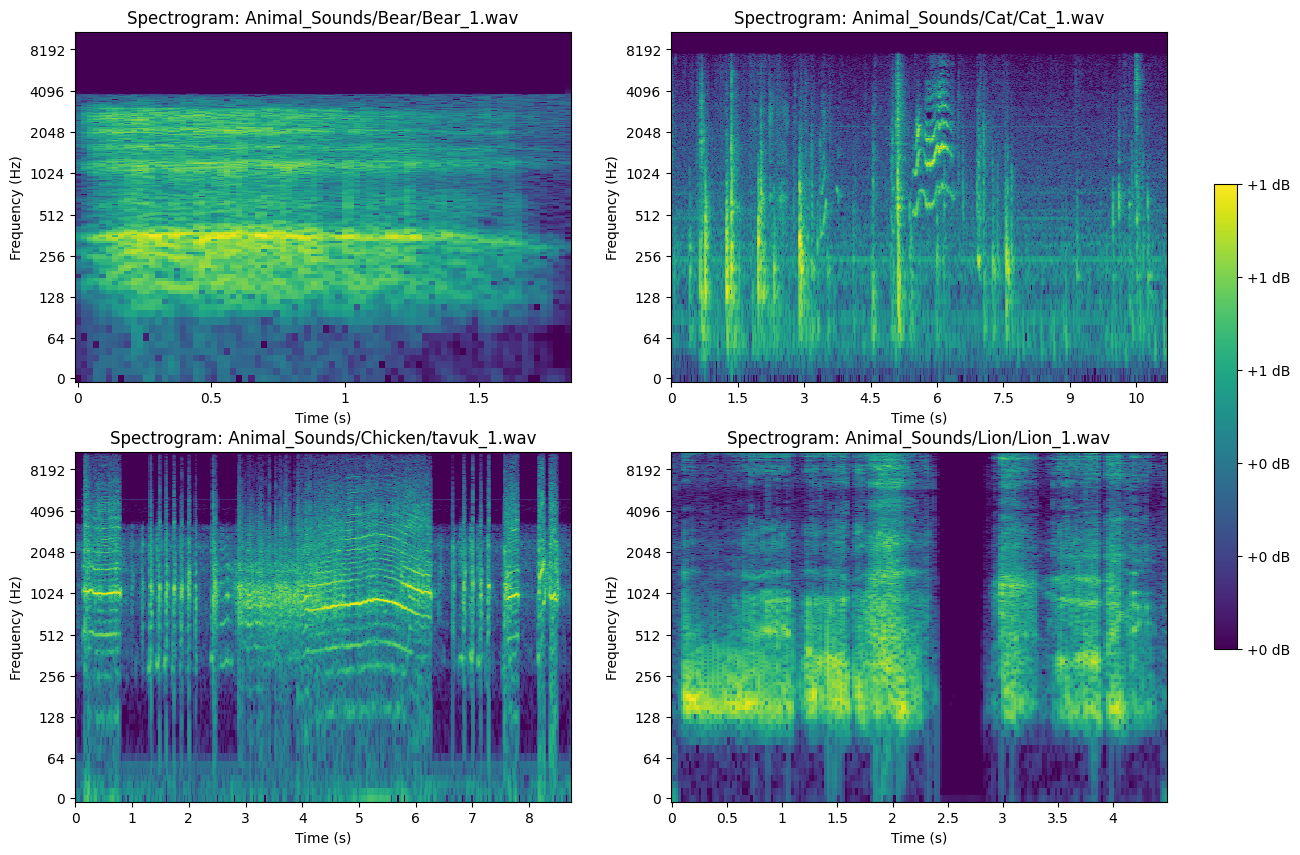

In [12]:
plot_spectrograms_grid(animals,rows=2,cols=2)

In [13]:
spectrogram_data = process_wav_directory_to_spectrogram_df(animal_dir)
spectrogram_data = spectrogram_data.fillna(0)
spectrogram_data

file_path = 'Animal Sounds/Cat/Cat_17.wav'
label = extract_label(file_path)
print(label)  

C:\Users\aabla\AppData\Roaming\Python\Python310\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Cat


### Run PCA on the Spectrogram-Extracted Features

Number of components selected: 105
Explained Variance Ratio: [4.69711202e-01 1.34353681e-01 6.26117496e-02 4.40874284e-02
 3.30310848e-02 2.31709858e-02 1.99450556e-02 1.43610017e-02
 1.23388517e-02 1.14467153e-02 9.16925118e-03 7.32171278e-03
 6.95324999e-03 5.56953568e-03 5.39254354e-03 4.81960549e-03
 4.32224963e-03 3.72572168e-03 3.55574348e-03 3.44450238e-03
 3.06465222e-03 2.96866077e-03 2.82471593e-03 2.34964541e-03
 2.20138516e-03 2.13904498e-03 2.00865673e-03 1.88338925e-03
 1.78801969e-03 1.69942511e-03 1.63549080e-03 1.55084268e-03
 1.41307382e-03 1.27597093e-03 1.24229317e-03 1.21196082e-03
 1.17393079e-03 1.14642608e-03 1.08009155e-03 1.03678589e-03
 9.77114121e-04 9.67492451e-04 9.24345903e-04 9.17589272e-04
 9.09438457e-04 8.97392551e-04 8.62505603e-04 8.53644378e-04
 7.67169476e-04 7.64623433e-04 7.38255432e-04 7.14244941e-04
 7.03387455e-04 6.87638312e-04 6.67172806e-04 6.58550606e-04
 6.42176220e-04 6.19318758e-04 6.10957182e-04 6.02715007e-04
 5.85511389e-04 5.633032

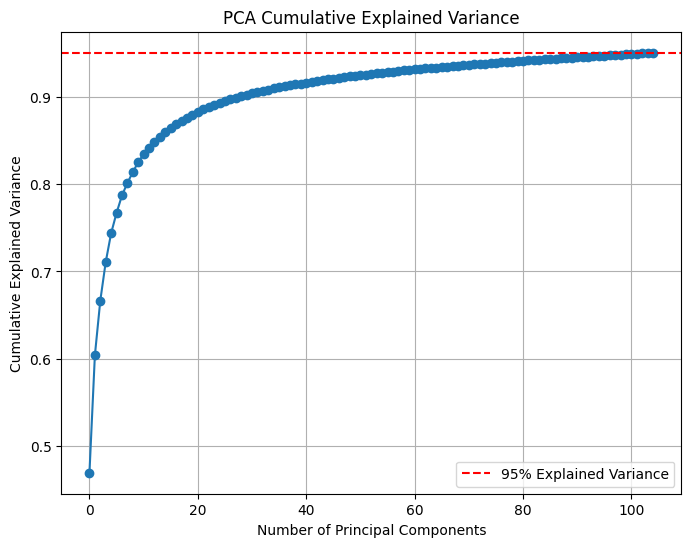

In [14]:
spectrogram_data_num = spectrogram_data.drop(columns="file_path") 

# Standardize the data
scaler = StandardScaler()
spectrogram_scaled = scaler.fit_transform(spectrogram_data_num)

# Apply PCA 
pca = PCA(n_components=0.95)  
principal_components_spectrogram = pca.fit_transform(spectrogram_data_num)

pca_df = pd.DataFrame(data=principal_components_spectrogram)

print(f"Number of components selected: {pca.n_components_}")
print("Explained Variance Ratio:", pca.explained_variance_ratio_)
print(f"Total variance explained: {sum(pca.explained_variance_ratio_):.2f}")

pca_df['file_path'] = spectrogram_data['file_path'].values
pca_df['animal_label'] = pca_df['file_path'].apply(extract_label)
pca_df = pca_df.drop(columns=["file_path"]) 
print(pca_df.head())

# Plot the cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Cumulative Explained Variance')
plt.axhline(y=0.95, color='r', linestyle='--', label="95% Explained Variance")
plt.legend(loc='best')
plt.grid()
plt.show()

### Perform KMeans clustering on the principal components

cluster        0   1   2   3  4   5  6   7  8   9
animal_label                                     
Bear          43   1   9   8  0  17  0  12  2   3
Bird           1   1  13  24  3   2  6  39  8   3
Cat           14  47   2   2  4   8  2   8  2  11
Chicken       19   1   0   2  0   5  2   0  0   1
Cow           63   0   3   1  0  35  0  19  4   0
Dog            1   7   9  26  4  16  0  24  7   6
Dolphin       42   0   1   0  0   7  0   0  0   0
Donkey        29   1   2   9  1  28  0   0  3   2
Elephant       9   0  11   5  0  13  0   8  2   2
Frog          43   1   7   6  2  14  1   4  3   4
Horse         15   0   0   0  0   8  0   8  0   0
Lion          12   1   9   6  2   4  2   8  2   4
Monkey         5   2   6   2  1   4  1   1  3   0
Sheep         22   1   2   4  1   8  0   2  0   0


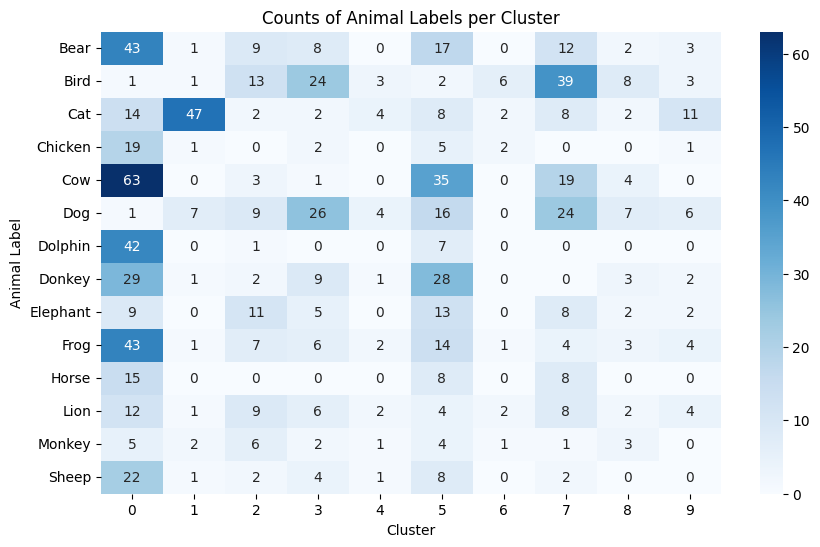

Adjusted Rand Index (ARI): 0.07
Normalized Mutual Information (NMI): 0.18
Homogeneity Score: 0.16
Completeness Score: 0.20
V-Measure Score: 0.18


In [15]:
# Apply K-Means
kmeans = KMeans(n_clusters=10, random_state=42)
pca_df['cluster'] = kmeans.fit_predict(principal_components_spectrogram)

# Create a Contingency Matrix
contingency_matrix_k_means = pd.crosstab(pca_df['animal_label'], pca_df['cluster'])

# Ensure all clusters and labels are represented
expected_clusters = range(kmeans.n_clusters)
expected_labels = sorted(pca_df['animal_label'].unique())
contingency_matrix_k_means = contingency_matrix_k_means.reindex(index=expected_labels, columns=expected_clusters, fill_value=0)
print(contingency_matrix_k_means)

plot_and_compute_metrics(pca_df, contingency_matrix_k_means, expected_clusters, expected_labels)

### Perform Spectral clustering on the principal components

C:\Users\aabla\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


cluster        0   1   2   3   4   5   6   7   8   9
animal_label                                        
Bear          15  16   3  18  12   0  19   0  12   0
Bird           0   0  10  24   0   0   1  24  24  17
Cat            8   9  62   6   0   0   7   0   8   0
Chicken        3   2   4   0   5  10   4   0   2   0
Cow           31  32   0  19  14   4  17   0   8   0
Dog           18   1  14  36   0   0   1   0  30   0
Dolphin        7  23   0   0   6   1  12   0   1   0
Donkey        14  14   3   4   7   2  20   0  11   0
Elephant      13   2   1   7   1   0   9   0  17   0
Frog          14  11   8   3   7  23   4   0  15   0
Horse         10   1   0   5   7   0   8   0   0   0
Lion           6   1   8  12   8   0   3   0  12   0
Monkey         2   0   4   2   2   0   5   0  10   0
Sheep          7   4   2   4   5   8   6   0   4   0


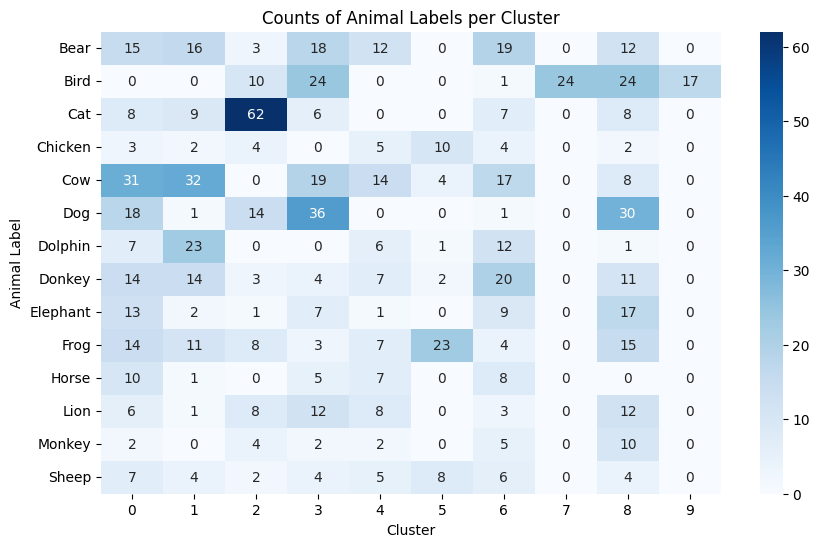

Adjusted Rand Index (ARI): 0.09
Normalized Mutual Information (NMI): 0.21
Homogeneity Score: 0.19
Completeness Score: 0.23
V-Measure Score: 0.21


In [16]:
# Apply Spectral Clustering
spectral_clustering = SpectralClustering(
    n_clusters=10, 
    affinity='nearest_neighbors', 
    random_state=42, 
    assign_labels='kmeans'
)
pca_df['cluster'] = spectral_clustering.fit_predict(principal_components_spectrogram)

# Create a Contingency Matrix
contingency_matrix_spectral = pd.crosstab(pca_df['animal_label'], pca_df['cluster'])

# Ensure all clusters and labels are represented
expected_clusters = range(10) 
expected_labels = sorted(pca_df['animal_label'].unique())
contingency_matrix_spectral = contingency_matrix_spectral.reindex(index=expected_labels, columns=expected_clusters, fill_value=0)
print(contingency_matrix_spectral)

plot_and_compute_metrics(pca_df, contingency_matrix_spectral, expected_clusters, expected_labels)

### Perform GMM clustering on the principal components

cluster        0   1   2   3  4   5  6   7  8   9
animal_label                                     
Bear          43   1   9   8  0  17  0  12  2   3
Bird           1   1  13  24  3   2  6  39  8   3
Cat           14  47   2   2  4   8  2   8  2  11
Chicken       19   1   0   2  0   5  2   0  0   1
Cow           63   0   3   1  0  35  0  19  4   0
Dog            1   7   9  26  4  16  0  24  7   6
Dolphin       42   0   1   0  0   7  0   0  0   0
Donkey        29   1   2   9  1  28  0   0  3   2
Elephant       9   0  11   5  0  13  0   8  2   2
Frog          43   1   7   6  2  14  1   4  3   4
Horse         15   0   0   0  0   8  0   8  0   0
Lion          12   1   9   6  2   4  2   8  2   4
Monkey         5   2   6   2  1   4  1   1  3   0
Sheep         22   1   2   4  1   8  0   2  0   0


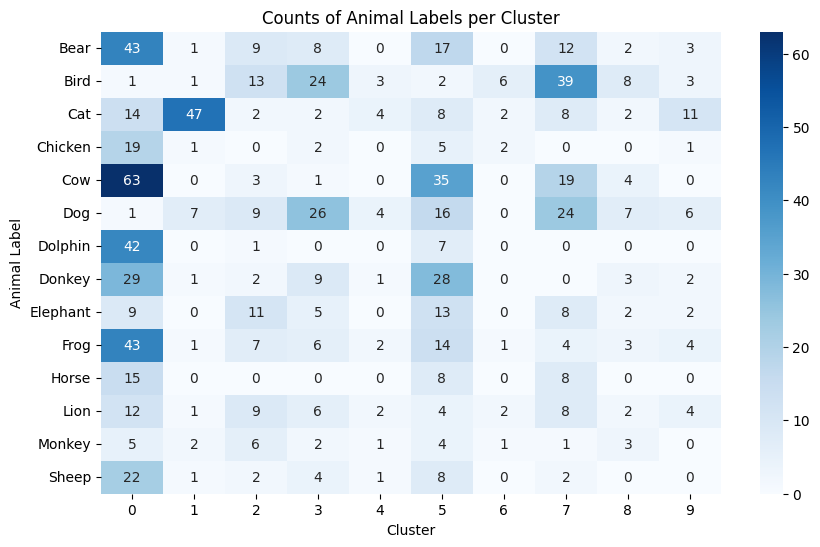

Adjusted Rand Index (ARI): 0.07
Normalized Mutual Information (NMI): 0.18
Homogeneity Score: 0.16
Completeness Score: 0.20
V-Measure Score: 0.18


In [17]:
# Apply Gaussian Mixture Model (GMM)
gmm = GaussianMixture(n_components=10, random_state=42)  
pca_df['cluster'] = gmm.fit_predict(principal_components_spectrogram)

# Create a Contingency Matrix
contingency_matrix_gmm = pd.crosstab(pca_df['animal_label'], pca_df['cluster'])

# Ensure all clusters and labels are represented
expected_clusters = range(gmm.n_components)
expected_labels = sorted(pca_df['animal_label'].unique())
contingency_matrix_gmm = contingency_matrix_gmm.reindex(index=expected_labels, columns=expected_clusters, fill_value=0)
print(contingency_matrix_gmm)

plot_and_compute_metrics(pca_df, contingency_matrix_gmm, expected_clusters, expected_labels)

### Perform Self-Organizing Maps clustering on the principal components

 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 5.829623805043348


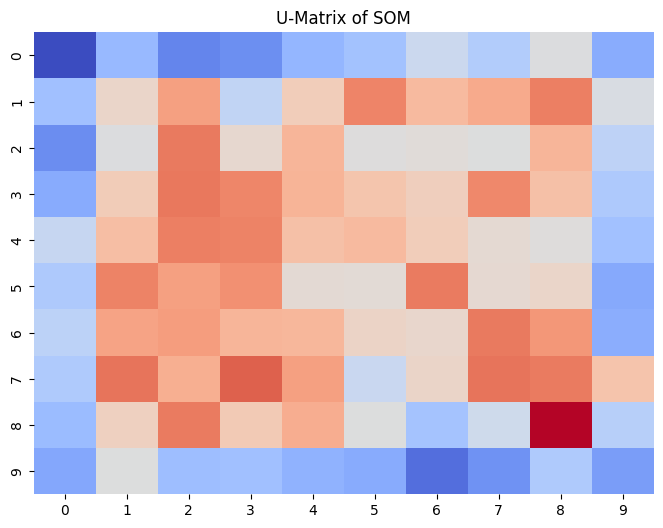

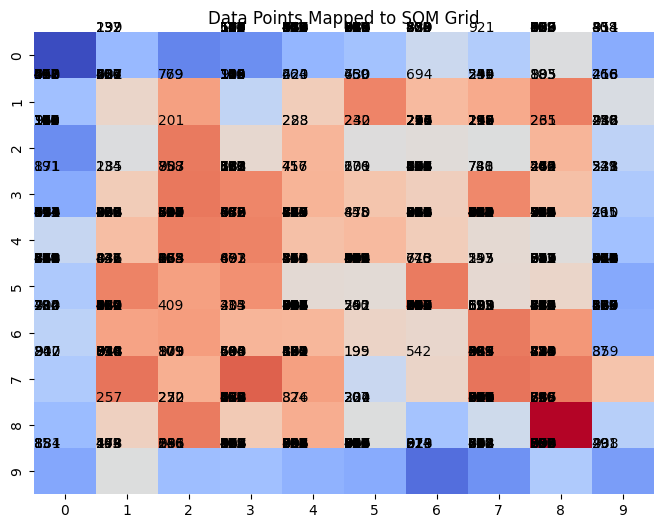

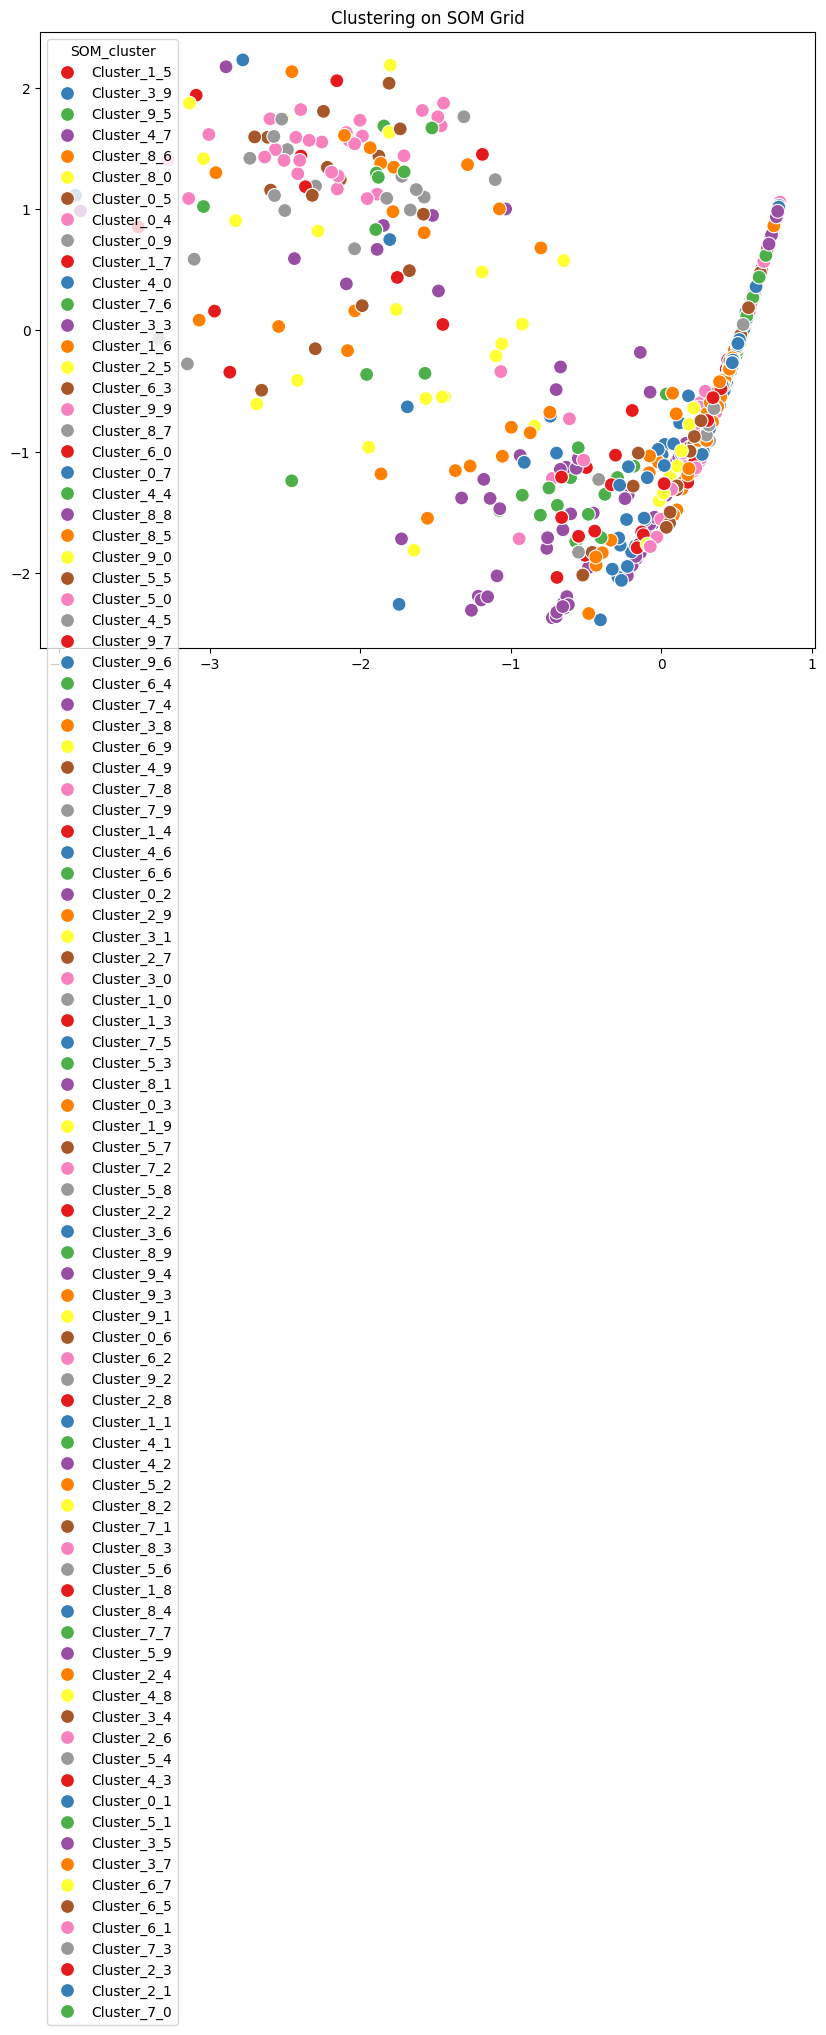

Adjusted Rand Index (ARI): 0.06
Normalized Mutual Information (NMI): 0.32
Homogeneity: 0.43
Completeness: 0.26
V-Measure: 0.32


In [18]:
# Standardize the data 
scaler = StandardScaler()
animal_scaled = scaler.fit_transform(principal_components_spectrogram) 

# Initialize the SOM
som = MiniSom(x=10, y=10, input_len=animal_scaled.shape[1], sigma=1.0, learning_rate=0.5, random_seed=42)

# Train the SOM
som.train(animal_scaled, 1000, verbose=True)

# Plot the SOM's U-matrix
# U-matrix visualizes the distance between the neurons in the SOM grid. Larger distances mean dissimilarity.
plt.figure(figsize=(8, 6))
plt.title("U-Matrix of SOM")
sns.heatmap(som.distance_map().T, cmap='coolwarm', cbar=False)
plt.show()

# Plot the data points on the SOM grid
plt.figure(figsize=(8, 6))
sns.heatmap(som.distance_map().T, cmap='coolwarm', cbar=False)

# Assign each data point to a neuron (winning node)
win_map = som.win_map(animal_scaled)

# We can use the same colors to show where the data points map on the SOM grid
for label in range(len(animal_scaled)):
    x, y = som.winner(animal_scaled[label])
    plt.text(x, y, str(label), color='black', fontsize=10)

plt.title('Data Points Mapped to SOM Grid')
plt.show()

# Visualize the SOM clusters
# Cluster the data points by grouping based on their winning node
# You can assign each point a cluster label (i.e., the coordinates of the winning node)
labels_som = np.array([som.winner(x) for x in animal_scaled])

# Convert coordinates to cluster labels
cluster_labels = np.array([f'Cluster_{x[0]}_{x[1]}' for x in labels_som])

pca_df['SOM_cluster'] = cluster_labels

# Visualize the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x=animal_scaled[:, 0], y=animal_scaled[:, 1], hue=pca_df['SOM_cluster'], palette='Set1', s=100)
plt.title("Clustering on SOM Grid")
plt.show()

# Clustering performance metrics
ari = adjusted_rand_score(pca_df['animal_label'], pca_df['SOM_cluster'])
print(f"Adjusted Rand Index (ARI): {ari:.2f}")

nmi = normalized_mutual_info_score(pca_df['animal_label'], pca_df['SOM_cluster'])
print(f"Normalized Mutual Information (NMI): {nmi:.2f}")

homogeneity = homogeneity_score(pca_df['animal_label'], pca_df['SOM_cluster'])
print(f"Homogeneity: {homogeneity:.2f}")

completeness = completeness_score(pca_df['animal_label'], pca_df['SOM_cluster'])
print(f"Completeness: {completeness:.2f}")

v_measure = v_measure_score(pca_df['animal_label'], pca_df['SOM_cluster'])
print(f"V-Measure: {v_measure:.2f}")

### Results of Spectrogram Feature Extraction Clustering Results

| **Method**              | **Adjusted Rand Index (ARI)** | **Normalized Mutual Information (NMI)** | **Homogeneity Score** | **Completeness Score** | **V-Measure Score** |
|--------------------------|------------------------------|------------------------------------------|------------------------|-------------------------|---------------------|
| K-means                 | 0.07                         | 0.18                                     | 0.16                   | 0.20                    | 0.18                |
| Spectral Clustering      | 0.09                         | 0.21                                     | 0.19                   | 0.23                    | 0.21                |
| GMM                     | 0.07                         | 0.18                                     | 0.16                   | 0.20                    | 0.18                |
| SOM                     | 0.06                         | 0.32                                     | 0.43                   | 0.26                    | 0.32                |


# Clustering Results

Overall, the Librosa feature extraction method performed better than the spectrogram feature extraction method because it transforms raw audio data into a compact, structured, and meaningful representation suitable for analysis. In contrast, the spectrogram method creates a high-dimensional representation of audio signals, which makes it more challenging for clustering algorithms to find clear groupings. 

Among the clustering methods, SOM peformed best likely due to its ability to hand non-linear relationships in the dataset. Unlike K-Means or GMM, which rely on spherical or Gaussian assumptions, SOM organizes data points based on similarity and maps them onto a low-dimensional grid. This approach preserves the relationships in the data, enabling SOM to group similar audio features more effectively. Also, SOM is more robust to noise and redundant features allowing it to focus on representing the overall structure rather than fitting rigid cluster assumptions. 

Librosa's features are specifically designed to filter out noise and focus on relevant audio characteristics, leading to slightly better clustering performance. On the other hand, spectrogram features suffer from poor alignment with clustering assumptions, resulting in weaker performance across the clustering algorithms.

Despite this, none of the clustering algorithms performed well on either feature extraction method. The features did not effectively capture meaningful patterns in the data, leading to poorly separated clusters. Consequently, classifying data from these clusters would not yield good results. Given these limitations, we pivoted to using a CNN for feature extraction and explored alternative classifiers to improve performance.

# Using cnn as feature extractor and various classifiers (word better)
we used mobile net pretrained (talk about what mobile net is and why we thought this would be good)

For the feature extraction model, we're using the MobileNet convolutional neural network (CNN). This model is an efficient CNN pre-trained on the ImageNet dataset. It's optimized for small datasets like the one we are using in this study. We add in a GlobalAveragePooling2D layer as well as a Dense layer for the feature extraction layers.

#### Loading and preprocessing functions

In [29]:
def preprocess_audio_file(file_path, target_shape=(224, 224)):

    try:
        y, sr = librosa.load(file_path, sr=None)
        
        if y is None or len(y) == 0:
            raise ValueError(f"Audio data is empty for file: {file_path}")
        
        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        resized_spec = resize(mel_spec_db, target_shape, mode='constant')
        
        rgb_spec = np.stack([resized_spec] * 3, axis=-1) / 255.0 

        return rgb_spec

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        raise

def process_directory_to_dataframe(parent_directory, target_shape=(224, 224)):

    data, labels = [], []
    for root, _, files in os.walk(parent_directory):
        label = os.path.basename(root)  
        for file in files:
            if file.endswith(".wav"):
                file_path = os.path.join(root, file)
                try:
                    spectrogram = preprocess_audio_file(file_path, target_shape)
                    if spectrogram is not None:
                        data.append(spectrogram)
                        labels.append(label)
                except Exception as e:
                    print(f"Skipping file {file_path} due to error: {e}")

    print(f"Processed {len(data)} files successfully.")
    return np.array(data), np.array(labels)

parent_directory = "Animal_Sounds"  

print("Processing audio files...")
X, y = process_directory_to_dataframe(parent_directory)

print("Encoding labels...")
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

print("Splitting data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

Processing audio files...
Processed 956 files successfully.
Encoding labels...
Splitting data into train and test sets...


## logistic regression classifier

### Implement and Train the logistic regression classifier

### Breakdown of MobileNet Feature Extraction and Logistic Regression Training

This code below uses a pre-trained MobileNet model for feature extraction, followed by training and evaluating a Logistic Regression classifier.

#### Step 1: Load Pre-trained MobileNet
- The `MobileNet` model, pre-trained on the ImageNet dataset, is loaded using Keras.
- Parameters:
  - `weights='imagenet'`: Loads weights pre-trained on the ImageNet dataset.
  - `include_top=False`: Excludes the fully connected layers, allowing the model to be used as a feature extractor.
  - `input_shape=(224, 224, 3)`: Specifies the input dimensions for the model (224x224 pixels with 3 color channels).

#### Step 2: Create a Feature Extractor
- The `feature_extractor_model` is built by adding layers on top of the pre-trained MobileNet model:
  - `GlobalAveragePooling2D()`: Converts the feature maps into a single vector per image.
  - `Dense(256, activation='relu')`: Adds a fully connected layer with 256 neurons and ReLU activation to learn more complex features.

#### Step 3: Data Augmentation
- The `ImageDataGenerator` performs data augmentation to improve model generalization by:
  - Rotating images (up to 10 degrees).
  - Shifting images horizontally and vertically (up to 10% of their width/height).
  - Flipping images horizontally.
- The `datagen.fit(X_train)` step applies the augmentation to the training data.

#### Step 4: Feature Extraction
- The augmented training and testing datasets (`X_train` and `X_test`) are passed through the `feature_extractor_model`.
- The model outputs feature vectors that represent the high-level characteristics of the input images.

#### Step 5: Train Logistic Regression Classifier
- A Logistic Regression model is trained on the extracted feature vectors:
  - `multi_class='multinomial'`: Implements multinomial Logistic Regression for multi-class classification.
  - `solver='lbfgs'`: An efficient solver for small to medium-sized datasets.
  - `max_iter=1000`: Sets the maximum number of iterations to ensure convergence.


Finally, the model makes predictions and is evaluated using a standard confusion matrix.

Loading pre-trained MobileNet model...
Extracting features using the pre-trained MobileNet model...
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 621ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 593ms/step
Training the Logistic Regression classifier...


C:\Users\aabla\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Evaluating the Logistic Regression classifier...
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.63      0.53        19
           1       0.93      1.00      0.96        13
           2       0.78      0.58      0.67        24
           3       0.67      0.60      0.63        10
           4       0.88      1.00      0.93        21
           5       0.62      0.73      0.67        22
           6       0.78      0.88      0.82         8
           7       0.85      0.79      0.81        14
           8       0.91      0.83      0.87        12
           9       0.74      1.00      0.85        14
          10       1.00      0.83      0.91         6
          11       0.14      0.08      0.11        12
          12       0.67      0.33      0.44         6
          13       0.88      0.64      0.74        11

    accuracy                           0.72       192
   macro avg       0.73      0.71      0.71       192
weighted

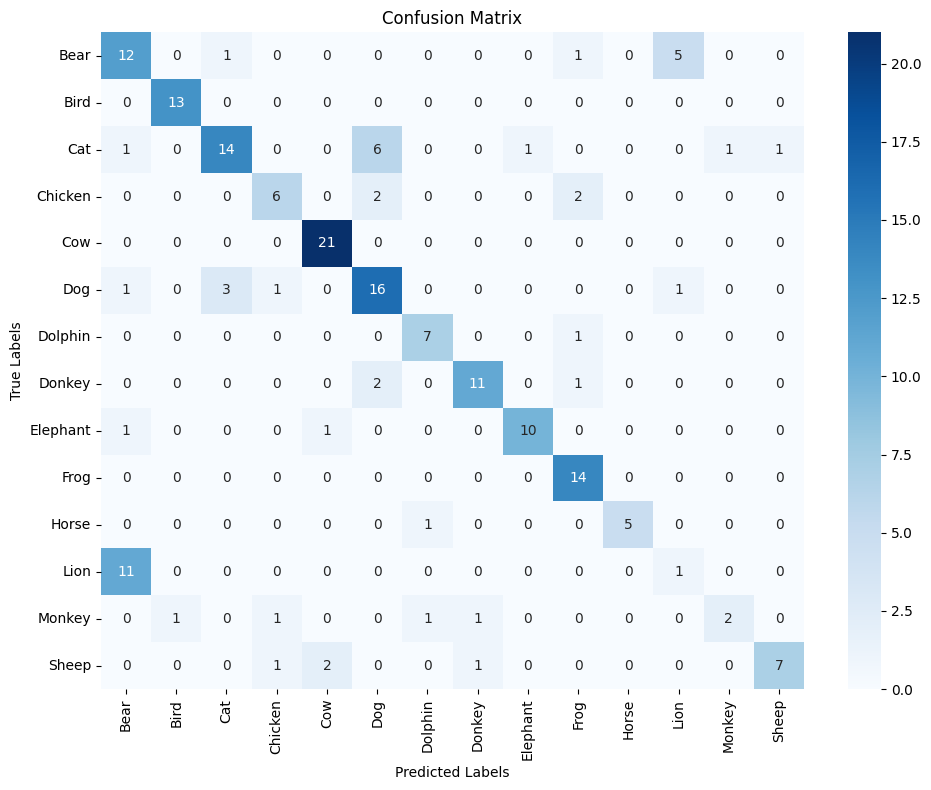

In [30]:
# Load pre-trained MobileNet model
print("Loading pre-trained MobileNet model...")
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a feature extractor from the pre-trained model
feature_extractor_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu')  
])

# Data augmentation and training
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
datagen.fit(X_train)

# Extract features for training and testing data
print("Extracting features using the pre-trained MobileNet model...")
X_train_features = feature_extractor_model.predict(X_train)
X_test_features = feature_extractor_model.predict(X_test)

# Train Logistic Regression Classifier
print("Training the Logistic Regression classifier...")
lr_model = LogisticRegression(
    max_iter=1000,  
    random_state=42,
    multi_class='multinomial',  
    solver='lbfgs'              
)
lr_model.fit(X_train_features, np.argmax(y_train, axis=1))

# Evaluate the Model
print("Evaluating the Logistic Regression classifier...")
y_pred = lr_model.predict(X_test_features)

# Classification Report
print("Classification Report:")
print(classification_report(np.argmax(y_test, axis=1), y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

### Logistic Regression Analysis

Using logistic regression as a classifier achieved moderate success, with an overall accuracy of 72%. This performance can be attributed to the simplicity and interpretability of the features extracted by the CNN, which allowed logistic regression to classify many classes effectively. Logistic regression also benefits from being resistant to overfitting, particularly when dealing with high-dimensional feature spaces like those produced by CNNs.

However, the results showed significant variability between classes, indicating challenges that limited the classifier's performance. These challenges likely stem from two key factors:

- Imbalanced Class Representation: Some classes were underrepresented in the dataset, which caused the classifier to prioritize majority classes, leading to poorer performance for minority classes.
- Overlapping Feature Distributions: Certain classes shared similar audio characteristics, making it difficult for both the CNN feature extractor and the linear decision boundaries of logistic regression to distinguish them. For instance, the audio files for "bear" and "lion" might have similar tonal features or spectral patterns, resulting in frequent misclassification.

## RNN classifier

### Feature Extraction

The code below implements a hybrid pipeline combining a pre-trained MobileNet model for feature extraction and a Recurrent Neural Network (RNN) for classification.

#### Step 1: Load Pre-trained MobileNet
- The `MobileNet` model, pre-trained on the ImageNet dataset, is loaded using Keras.
- Parameters:
  - `weights='imagenet'`: Loads weights pre-trained on the ImageNet dataset.
  - `include_top=False`: Excludes the fully connected layers, allowing MobileNet to be used as a feature extractor.
  - `input_shape=(224, 224, 3)`: Specifies the input image dimensions (224x224 pixels with 3 color channels).

#### Step 2: Create a Feature Extractor
- A `Sequential` model is built on top of MobileNet, consisting of:
  - `GlobalAveragePooling2D()`: Reduces the spatial dimensions of the feature maps into a single vector per image.
  - `Dense(256, activation='relu')`: A fully connected layer with 256 neurons to learn compact feature embeddings.

#### Step 3: Data Augmentation
- The `ImageDataGenerator` applies data augmentation to the training data:
  - Rotates images up to 10 degrees.
  - Shifts images horizontally and vertically by up to 10% of their dimensions.
  - Flips images horizontally.
- The augmented images improve the model's generalization ability.

#### Step 4: Extract Features
- The pre-trained MobileNet-based `feature_extractor_model` is used to extract high-level features from the training (`X_train`) and testing (`X_test`) datasets.
- Output:
  - `X_train_features` and `X_test_features`: Feature vectors for each image.

#### Step 5: Reshape Features for RNN Input
- Since RNNs operate on sequential data, the extracted feature vectors are reshaped to include a timestep dimension:
  - `timesteps = 1`: Each feature vector is treated as a single timestep.
  - `X_train_rnn` and `X_test_rnn`: Reshaped features suitable for RNN input.

#### Step 6: Build the CNN + RNN Hybrid Model
- A hybrid model is constructed, combining convolutional and recurrent layers:
  - `TimeDistributed(Dense(128, activation='relu'))`: Applies a fully connected layer to each timestep of the input.
  - `LSTM(128, return_sequences=False)`: An LSTM layer with 128 units for temporal modeling of sequential data.
  - `Dropout(0.5)`: Prevents overfitting by randomly dropping 50% of the neurons during training.
  - `Dense(y_train.shape[1], activation='softmax')`: The output layer uses the softmax activation for multi-class classification.

Finally, the model is compiled, and is ready to be trained on the data and assessed on its accuracy, which occurs in the code directly following its instantiation and compilation.

In [31]:
# Load pre-trained MobileNet model
print("Loading pre-trained MobileNet model...")
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a feature extractor from the pre-trained model
feature_extractor_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu')  # Feature embedding layer
])

# Data augmentation and training
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
datagen.fit(X_train)

# Extract features for training and testing data
print("Extracting features using the pre-trained MobileNet model...")
X_train_features = feature_extractor_model.predict(X_train)
X_test_features = feature_extractor_model.predict(X_test)

# Reshape features for RNN input
timesteps = 1  
X_train_rnn = X_train_features.reshape(X_train_features.shape[0], timesteps, -1)
X_test_rnn = X_test_features.reshape(X_test_features.shape[0], timesteps, -1)

# Build the RNN model
print("Building the CNN + RNN hybrid model...")

rnn_model = Sequential([
    TimeDistributed(Dense(128, activation='relu'), input_shape=(timesteps, X_train_rnn.shape[2])),
    LSTM(128, return_sequences=False),  # LSTM for temporal modeling
    Dropout(0.5),
    Dense(y_train.shape[1], activation='softmax')  # Classification layer
])

# Compile the model
optimizer = AdamW(learning_rate=0.001, weight_decay=1e-4)
rnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
rnn_model.summary()

Loading pre-trained MobileNet model...
Extracting features using the pre-trained MobileNet model...
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 651ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 606ms/step
Building the CNN + RNN hybrid model...


C:\Users\aabla\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 1, 128)         │        32,896 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 14)             │         1,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,286 (649.55 KB)

 Trainable params: 166,286 (649.55 KB)

 Non-trainable params: 0 (0.00 B)

### Train the RNN classifier

Training the CNN + RNN hybrid model...
Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9408 - loss: 0.2022 - val_accuracy: 0.7188 - val_loss: 0.8297 - learning_rate: 1.0000e-06
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9447 - loss: 0.1822 - val_accuracy: 0.7188 - val_loss: 0.8297 - learning_rate: 1.0000e-06
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9571 - loss: 0.1713 - val_accuracy: 0.7188 - val_loss: 0.8298 - learning_rate: 1.0000e-06
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9405 - loss: 0.1960 - val_accuracy: 0.7188 - val_loss: 0.8298 - learning_rate: 1.0000e-06
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9354 - loss: 0.2044 - val_accuracy: 0.7135 - val_loss: 0.8299 - learning_rate: 1.0000e-06
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9456 - loss: 0.1797 - val_accuracy: 0.7135 - val_loss: 0.8300 - learning_rate: 1.0000e-06
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━

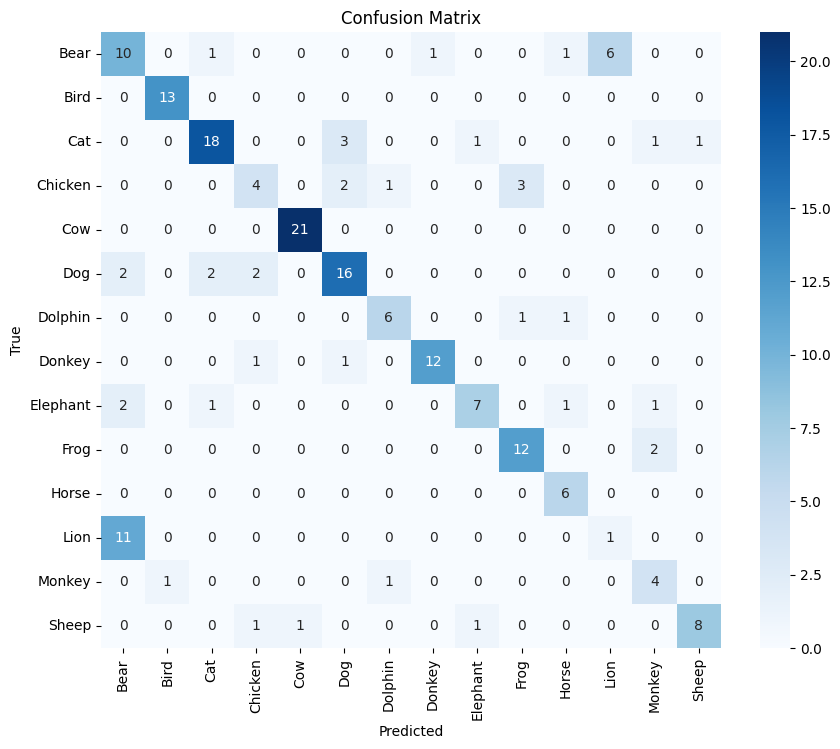

In [44]:
# Train the model
print("Training the CNN + RNN hybrid model...")

# Early Stopping to reduce overfitting by stopping training when validation loss does not change for 5 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Learning Rate Scheduler to reduce LR when validation loss plateaus
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,          # Reduce LR by a factor of 0.5
    patience=3,          # Wait 3 epochs before reducing LR
    verbose=1,
    min_lr=1e-6          # Minimum learning rate
)

history = rnn_model.fit(
    X_train_rnn, y_train,
    validation_data=(X_test_rnn, y_test),
    epochs=50,
    callbacks=[early_stopping,lr_scheduler],
    verbose=1
)

# Evaluate the model
test_loss, test_accuracy = rnn_model.evaluate(X_test_rnn, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.2f}")

y_pred_probs = rnn_model.predict(X_test_rnn)  # Predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Predicted classes
y_true = np.argmax(y_test, axis=1)  # True classes

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### RNN Analysis

Using an RNN as a classifier achieved an overall accuracy of 72% on the dataset, similar to logistic regression. This is likely due to the RNN's ability to capture temporal relationships and patterns inherent in audio data. Additionally, RNNs can model complex, non-linear relationships, making them better suited for datasets with overlapping class distributions compared to the linear decision boundaries of logistic regression.

However, using an RNN also comes with some weaknesses. Similar to logistic regression, the RNN struggled with class imbalance, leading to poor performance on minority classes. Furthermore, the RNN likely faced difficulties distinguishing between classes with similar audio characteristics, particularly when the CNN feature extraction did not provide clear separability in the feature space. RNNs are also prone to overfitting especially on small or noisy datasets. 



## SVM classifier

### Feature Extraction and Training

Loading pre-trained MobileNet model...
Extracting features using the pre-trained MobileNet model...
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 635ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 637ms/step
Training the SVM classifier...
Evaluating the SVM classifier...
Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.68      0.55        19
           1       0.93      1.00      0.96        13
           2       0.77      0.71      0.74        24
           3       0.57      0.40      0.47        10
           4       0.95      0.95      0.95        21
           5       0.71      0.77      0.74        22
           6       0.67      0.75      0.71         8
           7       1.00      0.79      0.88        14
           8       0.73      0.67      0.70        12
           9       0.78      1.00      0.88        14
          10       0.80      0.67      0.73         6
          11       0.14      0.08      0.11        12
          12       1.00      

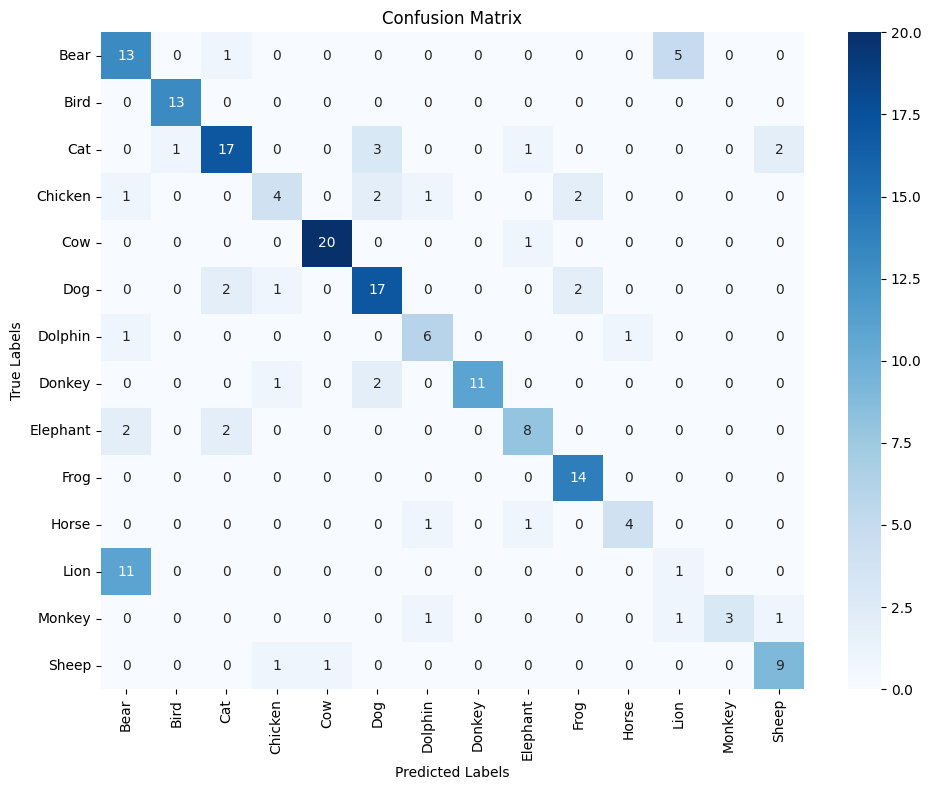

In [33]:
# Load pre-trained MobileNet model
print("Loading pre-trained MobileNet model...")
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a feature extractor from the pre-trained model
feature_extractor_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu')  # Feature embedding layer
])

# Data augmentation and training
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
datagen.fit(X_train)

# Extract features for training and testing data
print("Extracting features using the pre-trained MobileNet model...")
X_train_features = feature_extractor_model.predict(X_train)
X_test_features = feature_extractor_model.predict(X_test)

# Train-Test Split after PCA
print("Training the SVM classifier...")

# Train SVM
svm_classifier = SVC(kernel='linear', probability=True, random_state=42)
svm_classifier.fit(X_train_features, np.argmax(y_train, axis=1))

# Evaluate SVM
print("Evaluating the SVM classifier...")
y_pred = svm_classifier.predict(X_test_features)

# Classification Report
print("Classification Report:")
print(classification_report(np.argmax(y_test, axis=1), y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

### SVM Analysis

Using an SVM classifier achieved an overall accuracy of 73%, which is comparable to the logistic regression classifier and the RNN classifier. SVMs are particularly effective in high-dimensional spaces, making them well-suited for the CNN-derived features. By using a linear kernel, the SVM performed well for well-represented and distinctive classes, effectively leveraging the separability of the CNN features without overfitting.

However, the classifier struggled with challenges similar to those faced by logistic regression and RNNs. The imbalance in class representation led to underperformance in minority classes, as the SVM prioritized majority classes during optimization. Additionally, overlapping feature distributions between certain classes likely hindered the SVM's ability to form distinct boundaries, especially when constrained to linear decision surfaces.

## XGBoost classifier

### Feature Extraction and Training

Loading pre-trained MobileNet model...
Extracting features using the pre-trained MobileNet model...
24/24 ━━━━━━━━━━━━━━━━━━━━ 16s 630ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 615ms/step
Applying PCA to extracted features...
Number of components selected by PCA: 108
Training the XGBoost classifier...


C:\Users\aabla\AppData\Roaming\Python\Python310\site-packages\xgboost\core.py:158: UserWarning: [16:34:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Evaluating the XGBoost classifier...
Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.47      0.40        19
           1       0.72      1.00      0.84        13
           2       0.74      0.71      0.72        24
           3       1.00      0.40      0.57        10
           4       0.78      1.00      0.88        21
           5       0.75      0.68      0.71        22
           6       0.50      0.62      0.56         8
           7       0.85      0.79      0.81        14
           8       0.86      0.50      0.63        12
           9       0.71      0.86      0.77        14
          10       0.67      0.67      0.67         6
          11       0.09      0.08      0.09        12
          12       0.80      0.67      0.73         6
          13       1.00      0.45      0.62        11

    accuracy                           0.66       192
   macro avg       0.70      0.64      0.64       192
weighted avg       0

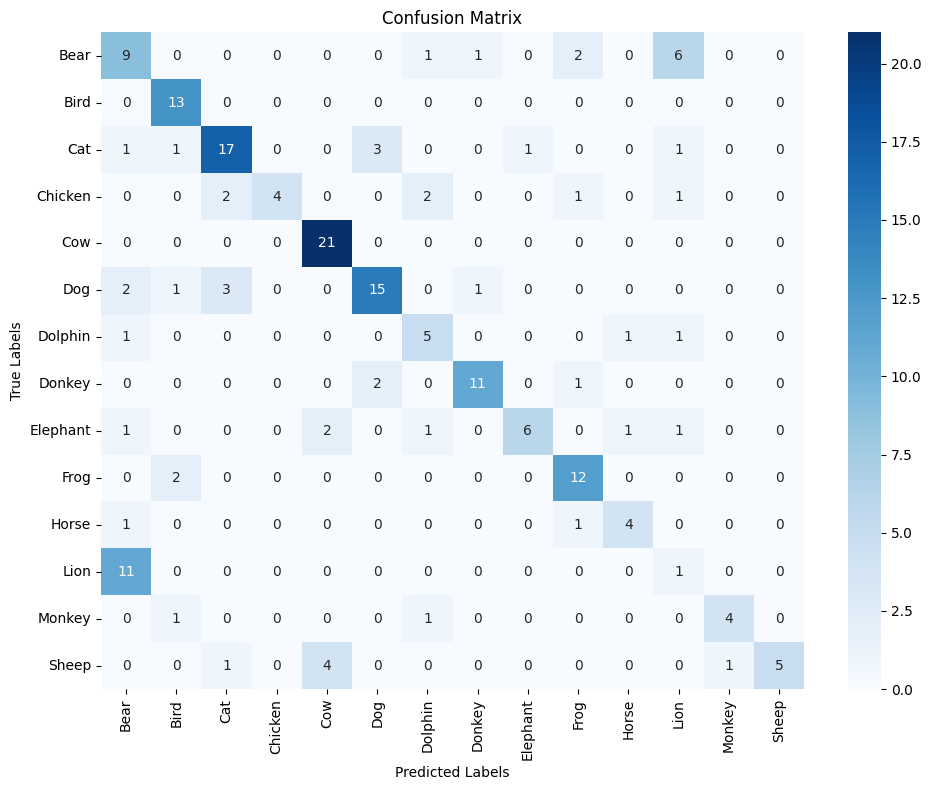

In [34]:
# Load pre-trained MobileNet model
print("Loading pre-trained MobileNet model...")
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a feature extractor from the pre-trained model
feature_extractor_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu')  # Feature embedding layer
])

# Data augmentation and training
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
datagen.fit(X_train)

# Extract features for training and testing data
print("Extracting features using the pre-trained MobileNet model...")
X_train_features = feature_extractor_model.predict(X_train)
X_test_features = feature_extractor_model.predict(X_test)

# Apply PCA
print("Applying PCA to extracted features...")
pca = PCA(n_components=0.95) 
X_train_pca = pca.fit_transform(X_train_features)
X_test_pca = pca.transform(X_test_features)

# Check the number of components selected
print(f"Number of components selected by PCA: {pca.n_components_}")

# Train XGBoost Classifier
print("Training the XGBoost classifier...")
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # Multiclass classification
    num_class=y_train.shape[1],  # Number of classes
    use_label_encoder=False,     # Suppress warnings
    eval_metric='mlogloss',      # Log loss for multiclass
    random_state=42
)

xgb_model.fit(X_train_features, np.argmax(y_train, axis=1))

# Evaluate the Model
print("Evaluating the XGBoost classifier...")
y_pred = xgb_model.predict(X_test_features)

# Classification Report
print("Classification Report:")
print(classification_report(np.argmax(y_test, axis=1), y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

### XGBoost Analysis

Using an XGBoost classifier, the model achieved an overall accuracy of 66%, which is the lowest among the classifiers tested. XGBoost is well-suited for data with complex, non-linear patterns and has the ability to rank feature importance, allowing it to focus on the most relevant aspects of the CNN-extracted features. This strength contributed to its ability to perform reasonably well on well-represented classes with distinct patterns.

However, XGBoost performs best with larger datasets, which likely limited its effectiveness on our smaller dataset. Additionally, similar to the challenges experienced with the other classifiers, XGBoost struggled with class imbalance and overlapping class features, which reduced its ability to distinguish between minority classes and classes with similar characteristics. Unlike RNNs, XGBoost does not explicitly handle sequential relationships in the data, which may further explain its lower performance in this context.

## CNN as feature extractor and Various Classifiers results

| **Classifier**      | **Accuracy** | **Remarks**                                                                                       |
|----------------------|--------------|---------------------------------------------------------------------------------------------------|
| Logistic Regression  | 72%          | Performed well due to simplicity and resistance to overfitting but struggled with class imbalance and overlapping features. |
| RNN                  | 72%          | Matched logistic regression, leveraging sequential data but limited by class imbalance and overlapping features. |
| SVM (Linear Kernel)  | 73%          | Effective in high dimensions and for well-represented classes, but struggled with linear separability for overlapping features. |
| XGBoost              | 66%          | Lowest accuracy; excelled with non-linear relationships but hindered by small dataset size, class imbalance, and lack of sequential handling. |


# Discussion

### Overall Model Performance
Across all methods, we observed variability in performance, stemming from differences in feature extraction, dataset characteristics, and the inherent strengths and weaknesses of each clustering algorithm and classifier. The results highlight the critical role feature extraction plays in clustering and classification tasks, as well as the importance of balancing model complexity with dataset characteristics.


### Feature Extraction Methods
1. Librosa Features (MFCCs/Spectral Features)
    - Librosa's features outperformed spectrograms in clustering because they are specifically designed to summarize key audio characteristics in a compact, interpretable format. MFCCs, for example, mimic the way humans perceive sound, focusing on relevant frequency bands while filtering out noise and redundant information. This aligns well with clustering algorithms, which benefit from lower-dimensional, noise-free representations.

2. Spectrograms
    - Spectrogram features performed poorly in clustering due to their high-dimensional nature and the inclusion of a significant amount of irrelevant or noisy information. Clustering algorithms struggled to identify meaningful groupings in this raw and detailed representation, resulting in lower metrics across the board.

3. CNN Feature Extraction
    - The CNN-based feature extractor achieved the best results because it learned task-specific feature representations through its hierarchical structure. CNNs capture complex, non-linear patterns in the data while reducing dimensionality, leading to features that are better aligned with the decision boundaries of classifiers. This adaptability made CNN features superior for downstream classification tasks, particularly with logistic regression, RNNs, and SVMs.


### Clustering Results
The clustering results revealed important insights:

*Librosa Features*
- Best Performing Methods: SOM performed the best, leveraging its ability to handle non-linear relationships and organize data onto a grid that preserves similarities.
- Challenges: Even with Librosa's refined features, clustering algorithms struggled with poorly separated classes, limiting the practical utility of clusters.

*Spectrogram Features*
- Challenges: High-dimensionality and noise hindered clustering, as algorithms like K-Means and Spectral Clustering rely on clear patterns and spherical/Gaussian assumptions. SOM performed better than others due to its robustness to noise.

*Key Takeaway*
- Clustering on these features alone was not sufficient for meaningful classification. The limitations prompted a shift to CNN-based feature extraction.



### Classification Results
1. Logistic Regression
    - Performance: Achieved 72% accuracy, benefiting from the simplicity and interpretability of CNN features.
    - Strengths: Resistant to overfitting and effective for high-dimensional data with clear separability.
    - Weaknesses: Struggled with imbalanced classes and overlapping feature distributions, where linear decision boundaries were insufficient.
2. RNN
    - Performance: Also achieved 72% accuracy, leveraging sequential patterns in the audio data.
    - Strengths: Modeled temporal dependencies well, capturing non-linear relationships better than logistic regression.
    - Weaknesses: Shared challenges with class imbalance and overlapping features. Overfitting was a risk, particularly on the small dataset.
3. SVM (Linear Kernel)
    - Performance: Achieved the highest accuracy (73%), excelling in high-dimensional spaces like the CNN feature set.
    - Strengths: Effective for well-separated classes and resistant to overfitting.
    - Weaknesses: Limited by linear decision boundaries, which struggled with overlapping features.
4. XGBoost
    - Performance: Lowest accuracy (66%), despite its ability to model complex, non-linear relationships.
    - Strengths: Feature importance ranking allowed it to focus on relevant features.
    - Weaknesses: Small dataset size and lack of sequential handling limited its performance. Class imbalance and overlapping features exacerbated these issues.



### Why CNN Features Performed Best
CNN features were the most successful because they:

- Captured Non-linear Patterns: CNNs learn hierarchical features, enabling them to extract meaningful patterns from raw audio.
- Reduced Dimensionality: By condensing input data into a task-specific representation, CNN features aligned well with the decision-making process of classifiers.
- Handled Noise: CNNs inherently filter out irrelevant details, focusing on discriminative features.


### How to Improve the Models
1. Address Class Imbalance:

    - Oversampling minority classes or undersampling majority classes.
    - Using class-weighted loss functions to penalize misclassifications in underrepresented classes.

2. Enhance Feature Extraction:

    - Experiment with additional CNN architectures or hybrid models (e.g., CNN-RNN).
    - Incorporate domain-specific features (e.g., zero-crossing rate, spectral contrast) alongside learned features.

3. Expand the Dataset:

    - Increasing the number of samples would reduce overfitting and improve generalizability, particularly for classifiers like RNNs and XGBoost.

4. Refine Clustering:

    - Explore deep clustering techniques that combine feature learning and clustering into a single framework.

5. Optimize Classifiers:

    - Experiment with non-linear kernels for SVM.
    - Fine-tune hyperparameters for XGBoost and other classifiers to improve performance.

# Limitations

- Computational Power: Limited computational resources restricted our ability to experiment with larger and more complex models. With access to more powerful hardware, we could explore deeper neural networks, larger architectures, and more advanced techniques to improve performance.

- Time Constraints: Time was a limitation, preventing us from fully experimenting with alternative approaches and hyperparameter tuning. Given more time, we could explore additional feature extraction methods, fine-tune classifiers, and test different model architectures to achieve better results.

- Dataset Size: The small dataset size was a bottleneck. More data would have improved model generalization, reduced overfitting, and provided a more robust evaluation of the models. A larger dataset would also enable the use of data-hungry methods like XGBoost and deeper RNN architectures, which often excel with abundant training data.

# Conclusion

In this study, we explored various feature extraction methods and classification models to analyze audio data. While Librosa features outperformed spectrograms in clustering due to their compact and structured representation, CNN-based feature extraction yielded the best results overall, providing meaningful and discriminative features that significantly improved classification performance. Among the classifiers, SVM achieved the highest accuracy, closely followed by logistic regression and RNNs, with XGBoost performing the weakest due to dataset limitations.

Our findings emphasize the importance of effective feature extraction, as it directly impacts the performance of clustering and classification algorithms. Despite achieving moderate success, challenges such as class imbalance, overlapping features, and limited dataset size highlighted areas for improvement. With more computational resources, additional time, and a larger dataset, future work could focus on refining feature extraction techniques, addressing class imbalance, and exploring ensemble methods to achieve even better performance. Overall, this work lays a strong foundation for audio classification using both traditional and modern machine learning approaches.

# References

1. Mporas, I., Ganchev, T., Kocsis, O., Fakotakis, N., Jahn, O., Riede, K., & Schuchmann, K.-L. (2012). Automated Acoustic Classification of Bird Species from Real-Field Recordings. Proceedings  International Conference on Tools with Artificial Intelligence, ICTAI, 1. https://doi.org/10.1109/ICTAI.2012.110

2. Kahl, S., Wood, C., Eibl, M., & Klinck, H. (2020). BirdNET: A deep learning solution for avian diversity monitoring. Ecological Informatics, 57, 101062. https://doi.org/10.1016/j.ecoinf.2020.101062